In [1]:
import json
import os
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm

### Data preparation

In [2]:
from typing import Tuple

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import ConcatDataset

CINIC_MEAN = [0.47889522, 0.47227842, 0.43047404]
CINIC_STD = [0.24205776, 0.23828046, 0.25874835]


class AddGaussianNoise(object):
    def __init__(self, mean=0, std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        tensor = transforms.ToTensor()(img)
        noise = torch.randn_like(tensor) * self.std + self.mean
        noisy_tensor = tensor + noise
        noisy_img = transforms.ToPILImage()(noisy_tensor)
        return noisy_img


def get_data(
    data_path: str = ".",
    batch_size: int = 256,
    augmentation: bool = False,
) -> Tuple[
    torch.utils.data.DataLoader,
    torch.utils.data.DataLoader,
    torch.utils.data.DataLoader,
]:

    transform_train = (
        transforms.Compose(
            [
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ColorJitter(brightness=0.5, contrast=0.5),
                AddGaussianNoise(mean=0, std=0.005),
                transforms.RandomAffine(degrees=5, translate=(0.1, 0.1)),
                transforms.ToTensor(),
                transforms.Normalize(mean=CINIC_MEAN, std=CINIC_STD),
            ]
        )
        if augmentation
        else transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=CINIC_MEAN, std=CINIC_STD),
            ]
        )
    )
    train = torchvision.datasets.ImageFolder(
            data_path + "/train", transform=transform_train
    )
    valid = torchvision.datasets.ImageFolder(
            data_path + "/valid", transform=transform_train
    )
    combined_train_valid = ConcatDataset([train, valid])

    cinic_train = torch.utils.data.DataLoader(
        combined_train_valid,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
    )

    valid_and_test_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=CINIC_MEAN, std=CINIC_STD),
        ]
    )

    cinic_test = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder(
            data_path + "/test", transform=valid_and_test_transform
        ),
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )

    return cinic_train, cinic_test

### Model

In [3]:
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 64 x 16 x 16
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 128 x 8 x 8
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 256 x 4 x 4
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            # nn.Sigmoid(),
        )

    def forward(self, xb):
        return self.network(xb)

### Train and evaluation helper functions

In [4]:
import json

import matplotlib.pyplot as plt
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

LABELS = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]


def save_confusion_matrix(true_labels, predicted_labels, idx, filename):
    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Others', LABELS[idx]])
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, cmap="Blues")
    plt.xticks(rotation=45)
    plt.savefig(filename)

def train_epoch(device, model, criterion, optimizer, train_loader, idx_label = 0):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    for inputs, labels in train_loader:
        labels = torch.where(labels == idx_label, 1, 0)
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(
            device, non_blocking=True
        )
        optimizer.zero_grad()
    
        outputs = model(inputs).squeeze().float()
        labels = labels.float()

        outputs = outputs.squeeze().float()
        labels = labels.squeeze().float()

        # print(f'{outputs.shape = }')
        # print(f'{labels.shape = }')

        # print(f'{outputs.get_device() = }')
        # print(f'{labels.get_device() = }')
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_accuracy += calculate_accuracy(outputs, labels) * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = running_accuracy / len(train_loader.dataset)
    return epoch_loss, epoch_accuracy


def evaluate_model(device, model, criterion, test_loader, idx_label, save_cm=False, cm_path=None):
    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            labels = torch.where(labels == idx_label, 1, 0)
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(
                device, non_blocking=True
            )
            outputs = model(inputs)
            loss = criterion(outputs.squeeze().float(), labels.float())
            
            predictions.append(outputs)
            true_labels.append(labels)

            running_loss += loss.item() * inputs.size(0)
            running_accuracy += calculate_accuracy(outputs.squeeze(), labels) * inputs.size(0)

    if save_cm:
        predictions = torch.cat(predictions)
        true_labels = torch.cat(true_labels)
        predictions = torch.where(torch.nn.functional.sigmoid(predictions) > 0.5, 1, 0)
        true_labels = true_labels.cpu().numpy()
        predictions = predictions.cpu().numpy()
        save_confusion_matrix(true_labels, predictions, idx_label, cm_path)

    test_loss = running_loss / len(test_loader.dataset)
    test_accuracy = running_accuracy / len(test_loader.dataset)
    return test_loss, test_accuracy

def calculate_accuracy(outputs, labels):
    preds = torch.where(torch.nn.functional.sigmoid(outputs)> 0.5, 1, 0)

    assert torch.all(torch.logical_or(labels == 0, labels == 1)), "Labels should be binary (0 or 1)"
    assert torch.all(torch.logical_or(preds == 0, preds == 1)), "Predictions should be binary (0 or 1)"

    corrects = torch.sum(preds == labels.data).item()
    return corrects / len(labels)

def load_config(config_path):
    with open(config_path, "r") as f:
        config = json.load(f)
    return config


def plot_loss_and_acc(df, path):
    # Plot losses
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(df["Train Loss"], label="Train Loss")
    plt.title("Losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(df["Train Accuracy"], label="Train Accuracy")
    plt.title("Accuracies")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.savefig(path)

In [5]:
OPTIMIZERS = {
    "adam": torch.optim.Adam,
    "sgd": torch.optim.SGD,
}

SCHEDULERS = {
    "StepLR": torch.optim.lr_scheduler.StepLR,
    "CosineAnnealingLR": torch.optim.lr_scheduler.CosineAnnealingLR,
}

In [6]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

config = load_config('config.json')

cinic_directory = "../"
batch_size = config["training_params"]["batch_size"]

cinic_train, cinic_test = get_data(
    cinic_directory,
    batch_size=batch_size,
    augmentation=config["data_params"]["augmentation"],
)

Using device: cuda


In [7]:
config

{'data_params': {'augmentation': True},
 'model': {'seed': 1},
 'training_params': {'optimizer': 'sgd',
  'lr': 0.01,
  'no_epochs': 40,
  'batch_size': 256,
  'lr_scheduler': 'CosineAnnealingLR'},
 'lr_scheduler_params': {'T_max': 40, 'eta_min': 0},
 'early_stopping_params': {'patience': 5, 'min_delta': 0.001}}

In [8]:
LABELS = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

  2%|▎         | 1/40 [00:55<36:18, 55.86s/it]

Epoch [1/40], Train Loss: 1.0586, Train Accuracy: 0.5838


  5%|▌         | 2/40 [01:48<34:10, 53.97s/it]

Epoch [2/40], Train Loss: 0.8253, Train Accuracy: 0.7772


  8%|▊         | 3/40 [02:39<32:32, 52.78s/it]

Epoch [3/40], Train Loss: 0.7476, Train Accuracy: 0.8072


 10%|█         | 4/40 [03:30<31:06, 51.85s/it]

Epoch [4/40], Train Loss: 0.6852, Train Accuracy: 0.8246


 12%|█▎        | 5/40 [04:21<30:02, 51.50s/it]

Epoch [5/40], Train Loss: 0.6304, Train Accuracy: 0.8403


 15%|█▌        | 6/40 [05:11<29:00, 51.19s/it]

Epoch [6/40], Train Loss: 0.5941, Train Accuracy: 0.8499


 18%|█▊        | 7/40 [06:02<28:05, 51.09s/it]

Epoch [7/40], Train Loss: 0.5599, Train Accuracy: 0.8615


 20%|██        | 8/40 [06:53<27:10, 50.95s/it]

Epoch [8/40], Train Loss: 0.5379, Train Accuracy: 0.8673


 22%|██▎       | 9/40 [07:43<26:14, 50.79s/it]

Epoch [9/40], Train Loss: 0.5135, Train Accuracy: 0.8753


 25%|██▌       | 10/40 [08:34<25:22, 50.74s/it]

Epoch [10/40], Train Loss: 0.4937, Train Accuracy: 0.8804


 28%|██▊       | 11/40 [09:25<24:32, 50.79s/it]

Epoch [11/40], Train Loss: 0.4778, Train Accuracy: 0.8842


 30%|███       | 12/40 [10:16<23:42, 50.80s/it]

Epoch [12/40], Train Loss: 0.4622, Train Accuracy: 0.8887


 32%|███▎      | 13/40 [11:07<22:53, 50.86s/it]

Epoch [13/40], Train Loss: 0.4413, Train Accuracy: 0.8940


 35%|███▌      | 14/40 [11:58<22:04, 50.93s/it]

Epoch [14/40], Train Loss: 0.4251, Train Accuracy: 0.8967


 38%|███▊      | 15/40 [12:49<21:15, 51.02s/it]

Epoch [15/40], Train Loss: 0.4170, Train Accuracy: 0.8985


 40%|████      | 16/40 [13:40<20:25, 51.08s/it]

Epoch [16/40], Train Loss: 0.4028, Train Accuracy: 0.9035


 42%|████▎     | 17/40 [14:31<19:34, 51.06s/it]

Epoch [17/40], Train Loss: 0.3857, Train Accuracy: 0.9071


 45%|████▌     | 18/40 [15:22<18:44, 51.11s/it]

Epoch [18/40], Train Loss: 0.3779, Train Accuracy: 0.9097


 48%|████▊     | 19/40 [16:13<17:49, 50.94s/it]

Epoch [19/40], Train Loss: 0.3674, Train Accuracy: 0.9120


 50%|█████     | 20/40 [17:04<16:57, 50.90s/it]

Epoch [20/40], Train Loss: 0.3607, Train Accuracy: 0.9149


 52%|█████▎    | 21/40 [17:55<16:11, 51.12s/it]

Epoch [21/40], Train Loss: 0.3488, Train Accuracy: 0.9168


 55%|█████▌    | 22/40 [18:46<15:19, 51.08s/it]

Epoch [22/40], Train Loss: 0.3372, Train Accuracy: 0.9190


 57%|█████▊    | 23/40 [19:37<14:27, 51.05s/it]

Epoch [23/40], Train Loss: 0.3232, Train Accuracy: 0.9236


 60%|██████    | 24/40 [20:29<13:38, 51.13s/it]

Epoch [24/40], Train Loss: 0.3137, Train Accuracy: 0.9252


 62%|██████▎   | 25/40 [21:20<12:47, 51.19s/it]

Epoch [25/40], Train Loss: 0.3066, Train Accuracy: 0.9266


 65%|██████▌   | 26/40 [22:12<11:58, 51.33s/it]

Epoch [26/40], Train Loss: 0.2910, Train Accuracy: 0.9301


 68%|██████▊   | 27/40 [23:03<11:07, 51.31s/it]

Epoch [27/40], Train Loss: 0.2906, Train Accuracy: 0.9301


 70%|███████   | 28/40 [23:56<10:21, 51.79s/it]

Epoch [28/40], Train Loss: 0.2718, Train Accuracy: 0.9347


 72%|███████▎  | 29/40 [24:49<09:34, 52.21s/it]

Epoch [29/40], Train Loss: 0.2665, Train Accuracy: 0.9355


 75%|███████▌  | 30/40 [25:41<08:41, 52.14s/it]

Epoch [30/40], Train Loss: 0.2637, Train Accuracy: 0.9363


 78%|███████▊  | 31/40 [26:33<07:48, 52.11s/it]

Epoch [31/40], Train Loss: 0.2496, Train Accuracy: 0.9387


 80%|████████  | 32/40 [27:24<06:55, 51.90s/it]

Epoch [32/40], Train Loss: 0.2458, Train Accuracy: 0.9400


 82%|████████▎ | 33/40 [28:16<06:02, 51.86s/it]

Epoch [33/40], Train Loss: 0.2380, Train Accuracy: 0.9418


 85%|████████▌ | 34/40 [29:08<05:10, 51.78s/it]

Epoch [34/40], Train Loss: 0.2352, Train Accuracy: 0.9434


 88%|████████▊ | 35/40 [30:00<04:18, 51.78s/it]

Epoch [35/40], Train Loss: 0.2240, Train Accuracy: 0.9453


 90%|█████████ | 36/40 [30:51<03:26, 51.74s/it]

Epoch [36/40], Train Loss: 0.2211, Train Accuracy: 0.9465


 92%|█████████▎| 37/40 [31:43<02:35, 51.81s/it]

Epoch [37/40], Train Loss: 0.2141, Train Accuracy: 0.9479


 95%|█████████▌| 38/40 [32:35<01:43, 51.91s/it]

Epoch [38/40], Train Loss: 0.2165, Train Accuracy: 0.9475


 98%|█████████▊| 39/40 [33:27<00:51, 51.78s/it]

Epoch [39/40], Train Loss: 0.2154, Train Accuracy: 0.9484


100%|██████████| 40/40 [34:18<00:00, 51.47s/it]

Epoch [40/40], Train Loss: 0.2131, Train Accuracy: 0.9483


Test Accuracy: 0.9542


  2%|▎         | 1/40 [00:51<33:09, 51.01s/it]

Epoch [1/40], Train Loss: 1.1620, Train Accuracy: 0.4472


  5%|▌         | 2/40 [01:41<32:07, 50.72s/it]

Epoch [2/40], Train Loss: 0.8483, Train Accuracy: 0.7447


  8%|▊         | 3/40 [02:32<31:28, 51.03s/it]

Epoch [3/40], Train Loss: 0.7225, Train Accuracy: 0.8023


 10%|█         | 4/40 [03:24<30:37, 51.05s/it]

Epoch [4/40], Train Loss: 0.6636, Train Accuracy: 0.8255


 12%|█▎        | 5/40 [04:14<29:40, 50.87s/it]

Epoch [5/40], Train Loss: 0.6065, Train Accuracy: 0.8433


 15%|█▌        | 6/40 [05:05<28:51, 50.93s/it]

Epoch [6/40], Train Loss: 0.5664, Train Accuracy: 0.8588


 18%|█▊        | 7/40 [05:57<28:15, 51.37s/it]

Epoch [7/40], Train Loss: 0.5440, Train Accuracy: 0.8653


 20%|██        | 8/40 [06:49<27:21, 51.29s/it]

Epoch [8/40], Train Loss: 0.5218, Train Accuracy: 0.8724


 22%|██▎       | 9/40 [07:41<26:38, 51.56s/it]

Epoch [9/40], Train Loss: 0.5034, Train Accuracy: 0.8756


 25%|██▌       | 10/40 [08:33<25:51, 51.71s/it]

Epoch [10/40], Train Loss: 0.4745, Train Accuracy: 0.8854


 28%|██▊       | 11/40 [09:24<24:55, 51.58s/it]

Epoch [11/40], Train Loss: 0.4630, Train Accuracy: 0.8875


 30%|███       | 12/40 [10:16<24:06, 51.66s/it]

Epoch [12/40], Train Loss: 0.4499, Train Accuracy: 0.8915


 32%|███▎      | 13/40 [11:07<23:11, 51.54s/it]

Epoch [13/40], Train Loss: 0.4311, Train Accuracy: 0.8971


 35%|███▌      | 14/40 [11:59<22:26, 51.78s/it]

Epoch [14/40], Train Loss: 0.4166, Train Accuracy: 0.8989


 38%|███▊      | 15/40 [12:51<21:29, 51.58s/it]

Epoch [15/40], Train Loss: 0.4036, Train Accuracy: 0.9030


 40%|████      | 16/40 [13:43<20:42, 51.78s/it]

Epoch [16/40], Train Loss: 0.4004, Train Accuracy: 0.9047


 42%|████▎     | 17/40 [14:33<19:42, 51.42s/it]

Epoch [17/40], Train Loss: 0.3867, Train Accuracy: 0.9066


 45%|████▌     | 18/40 [15:26<18:56, 51.65s/it]

Epoch [18/40], Train Loss: 0.3748, Train Accuracy: 0.9098


 48%|████▊     | 19/40 [16:18<18:09, 51.86s/it]

Epoch [19/40], Train Loss: 0.3668, Train Accuracy: 0.9109


 50%|█████     | 20/40 [17:10<17:18, 51.91s/it]

Epoch [20/40], Train Loss: 0.3595, Train Accuracy: 0.9122


 52%|█████▎    | 21/40 [18:01<16:23, 51.78s/it]

Epoch [21/40], Train Loss: 0.3478, Train Accuracy: 0.9157


 55%|█████▌    | 22/40 [18:54<15:34, 51.94s/it]

Epoch [22/40], Train Loss: 0.3357, Train Accuracy: 0.9178


 57%|█████▊    | 23/40 [19:45<14:41, 51.84s/it]

Epoch [23/40], Train Loss: 0.3342, Train Accuracy: 0.9182


 60%|██████    | 24/40 [20:37<13:49, 51.85s/it]

Epoch [24/40], Train Loss: 0.3224, Train Accuracy: 0.9208


 62%|██████▎   | 25/40 [21:29<12:58, 51.90s/it]

Epoch [25/40], Train Loss: 0.3141, Train Accuracy: 0.9234


 65%|██████▌   | 26/40 [22:22<12:09, 52.08s/it]

Epoch [26/40], Train Loss: 0.3018, Train Accuracy: 0.9261


 68%|██████▊   | 27/40 [23:14<11:17, 52.08s/it]

Epoch [27/40], Train Loss: 0.2946, Train Accuracy: 0.9271


 70%|███████   | 28/40 [24:06<10:23, 52.00s/it]

Epoch [28/40], Train Loss: 0.2901, Train Accuracy: 0.9280


 72%|███████▎  | 29/40 [24:57<09:31, 51.96s/it]

Epoch [29/40], Train Loss: 0.2809, Train Accuracy: 0.9297


 75%|███████▌  | 30/40 [25:49<08:38, 51.86s/it]

Epoch [30/40], Train Loss: 0.2761, Train Accuracy: 0.9304


 78%|███████▊  | 31/40 [26:41<07:47, 51.89s/it]

Epoch [31/40], Train Loss: 0.2671, Train Accuracy: 0.9329


 80%|████████  | 32/40 [27:33<06:56, 52.02s/it]

Epoch [32/40], Train Loss: 0.2642, Train Accuracy: 0.9330


 82%|████████▎ | 33/40 [28:25<06:03, 51.94s/it]

Epoch [33/40], Train Loss: 0.2536, Train Accuracy: 0.9356


 85%|████████▌ | 34/40 [29:16<05:10, 51.67s/it]

Epoch [34/40], Train Loss: 0.2515, Train Accuracy: 0.9369


 88%|████████▊ | 35/40 [30:07<04:16, 51.32s/it]

Epoch [35/40], Train Loss: 0.2444, Train Accuracy: 0.9383


 90%|█████████ | 36/40 [30:58<03:25, 51.35s/it]

Epoch [36/40], Train Loss: 0.2412, Train Accuracy: 0.9390


 92%|█████████▎| 37/40 [31:48<02:33, 51.02s/it]

Epoch [37/40], Train Loss: 0.2385, Train Accuracy: 0.9396


 95%|█████████▌| 38/40 [32:39<01:42, 51.01s/it]

Epoch [38/40], Train Loss: 0.2381, Train Accuracy: 0.9401


 98%|█████████▊| 39/40 [33:30<00:51, 51.02s/it]

Epoch [39/40], Train Loss: 0.2325, Train Accuracy: 0.9410


100%|██████████| 40/40 [34:21<00:00, 51.55s/it]

Epoch [40/40], Train Loss: 0.2332, Train Accuracy: 0.9407


Test Accuracy: 0.9471


  2%|▎         | 1/40 [00:51<33:26, 51.44s/it]

Epoch [1/40], Train Loss: 1.3007, Train Accuracy: 0.2377


  5%|▌         | 2/40 [01:42<32:22, 51.12s/it]

Epoch [2/40], Train Loss: 1.1737, Train Accuracy: 0.5969


  8%|▊         | 3/40 [02:34<31:40, 51.37s/it]

Epoch [3/40], Train Loss: 1.1017, Train Accuracy: 0.6704


 10%|█         | 4/40 [03:25<30:46, 51.29s/it]

Epoch [4/40], Train Loss: 1.0297, Train Accuracy: 0.6993


 12%|█▎        | 5/40 [04:17<30:03, 51.52s/it]

Epoch [5/40], Train Loss: 0.9664, Train Accuracy: 0.7195


 15%|█▌        | 6/40 [05:08<29:14, 51.60s/it]

Epoch [6/40], Train Loss: 0.9098, Train Accuracy: 0.7412


 18%|█▊        | 7/40 [06:00<28:23, 51.62s/it]

Epoch [7/40], Train Loss: 0.8693, Train Accuracy: 0.7589


 20%|██        | 8/40 [06:53<27:41, 51.92s/it]

Epoch [8/40], Train Loss: 0.8361, Train Accuracy: 0.7711


 22%|██▎       | 9/40 [07:44<26:47, 51.87s/it]

Epoch [9/40], Train Loss: 0.8095, Train Accuracy: 0.7784


 25%|██▌       | 10/40 [08:36<25:56, 51.88s/it]

Epoch [10/40], Train Loss: 0.7775, Train Accuracy: 0.7924


 28%|██▊       | 11/40 [09:28<25:02, 51.81s/it]

Epoch [11/40], Train Loss: 0.7487, Train Accuracy: 0.8054


 30%|███       | 12/40 [10:19<24:01, 51.48s/it]

Epoch [12/40], Train Loss: 0.7230, Train Accuracy: 0.8133


 32%|███▎      | 13/40 [11:10<23:12, 51.58s/it]

Epoch [13/40], Train Loss: 0.6953, Train Accuracy: 0.8214


 35%|███▌      | 14/40 [12:02<22:17, 51.46s/it]

Epoch [14/40], Train Loss: 0.6838, Train Accuracy: 0.8228


 38%|███▊      | 15/40 [12:53<21:27, 51.50s/it]

Epoch [15/40], Train Loss: 0.6597, Train Accuracy: 0.8321


 40%|████      | 16/40 [13:45<20:40, 51.67s/it]

Epoch [16/40], Train Loss: 0.6389, Train Accuracy: 0.8360


 42%|████▎     | 17/40 [14:37<19:49, 51.72s/it]

Epoch [17/40], Train Loss: 0.6144, Train Accuracy: 0.8431


 45%|████▌     | 18/40 [15:29<18:59, 51.78s/it]

Epoch [18/40], Train Loss: 0.6070, Train Accuracy: 0.8441


 48%|████▊     | 19/40 [16:21<18:08, 51.83s/it]

Epoch [19/40], Train Loss: 0.5884, Train Accuracy: 0.8496


 50%|█████     | 20/40 [17:13<17:17, 51.86s/it]

Epoch [20/40], Train Loss: 0.5695, Train Accuracy: 0.8547


 52%|█████▎    | 21/40 [18:05<16:26, 51.91s/it]

Epoch [21/40], Train Loss: 0.5537, Train Accuracy: 0.8594


 55%|█████▌    | 22/40 [18:56<15:31, 51.74s/it]

Epoch [22/40], Train Loss: 0.5393, Train Accuracy: 0.8633


 57%|█████▊    | 23/40 [19:48<14:40, 51.79s/it]

Epoch [23/40], Train Loss: 0.5221, Train Accuracy: 0.8665


 60%|██████    | 24/40 [20:39<13:42, 51.39s/it]

Epoch [24/40], Train Loss: 0.5071, Train Accuracy: 0.8719


 62%|██████▎   | 25/40 [21:30<12:51, 51.42s/it]

Epoch [25/40], Train Loss: 0.4936, Train Accuracy: 0.8734


 65%|██████▌   | 26/40 [22:22<12:00, 51.48s/it]

Epoch [26/40], Train Loss: 0.4789, Train Accuracy: 0.8787


 68%|██████▊   | 27/40 [23:13<11:08, 51.40s/it]

Epoch [27/40], Train Loss: 0.4607, Train Accuracy: 0.8827


 70%|███████   | 28/40 [24:05<10:18, 51.51s/it]

Epoch [28/40], Train Loss: 0.4489, Train Accuracy: 0.8855


 72%|███████▎  | 29/40 [24:56<09:27, 51.55s/it]

Epoch [29/40], Train Loss: 0.4399, Train Accuracy: 0.8880


 75%|███████▌  | 30/40 [25:48<08:36, 51.61s/it]

Epoch [30/40], Train Loss: 0.4185, Train Accuracy: 0.8941


 78%|███████▊  | 31/40 [26:40<07:45, 51.68s/it]

Epoch [31/40], Train Loss: 0.4149, Train Accuracy: 0.8938


 80%|████████  | 32/40 [27:32<06:53, 51.73s/it]

Epoch [32/40], Train Loss: 0.3953, Train Accuracy: 0.8997


 82%|████████▎ | 33/40 [28:24<06:03, 51.96s/it]

Epoch [33/40], Train Loss: 0.3881, Train Accuracy: 0.9023


 85%|████████▌ | 34/40 [29:16<05:11, 51.94s/it]

Epoch [34/40], Train Loss: 0.3788, Train Accuracy: 0.9037


 88%|████████▊ | 35/40 [30:09<04:20, 52.09s/it]

Epoch [35/40], Train Loss: 0.3691, Train Accuracy: 0.9059


 90%|█████████ | 36/40 [30:59<03:26, 51.62s/it]

Epoch [36/40], Train Loss: 0.3616, Train Accuracy: 0.9076


 92%|█████████▎| 37/40 [31:49<02:33, 51.15s/it]

Epoch [37/40], Train Loss: 0.3533, Train Accuracy: 0.9098


 95%|█████████▌| 38/40 [32:40<01:41, 50.92s/it]

Epoch [38/40], Train Loss: 0.3448, Train Accuracy: 0.9120


 98%|█████████▊| 39/40 [33:31<00:51, 51.02s/it]

Epoch [39/40], Train Loss: 0.3452, Train Accuracy: 0.9120


100%|██████████| 40/40 [34:22<00:00, 51.56s/it]

Epoch [40/40], Train Loss: 0.3421, Train Accuracy: 0.9125


Test Accuracy: 0.9180


  2%|▎         | 1/40 [00:51<33:15, 51.18s/it]

Epoch [1/40], Train Loss: 1.2907, Train Accuracy: 0.2059


  5%|▌         | 2/40 [01:41<32:11, 50.84s/it]

Epoch [2/40], Train Loss: 1.1411, Train Accuracy: 0.5516


  8%|▊         | 3/40 [02:33<31:39, 51.33s/it]

Epoch [3/40], Train Loss: 1.0343, Train Accuracy: 0.6403


 10%|█         | 4/40 [03:24<30:41, 51.16s/it]

Epoch [4/40], Train Loss: 0.9834, Train Accuracy: 0.6678


 12%|█▎        | 5/40 [04:16<29:57, 51.35s/it]

Epoch [5/40], Train Loss: 0.9488, Train Accuracy: 0.6887


 15%|█▌        | 6/40 [05:06<28:54, 51.00s/it]

Epoch [6/40], Train Loss: 0.9191, Train Accuracy: 0.7018


 18%|█▊        | 7/40 [05:57<27:57, 50.82s/it]

Epoch [7/40], Train Loss: 0.9030, Train Accuracy: 0.7057


 20%|██        | 8/40 [06:47<27:03, 50.72s/it]

Epoch [8/40], Train Loss: 0.8768, Train Accuracy: 0.7181


 22%|██▎       | 9/40 [07:39<26:21, 51.00s/it]

Epoch [9/40], Train Loss: 0.8583, Train Accuracy: 0.7238


 25%|██▌       | 10/40 [08:30<25:36, 51.23s/it]

Epoch [10/40], Train Loss: 0.8412, Train Accuracy: 0.7321


 28%|██▊       | 11/40 [09:21<24:40, 51.06s/it]

Epoch [11/40], Train Loss: 0.8182, Train Accuracy: 0.7461


 30%|███       | 12/40 [10:11<23:42, 50.82s/it]

Epoch [12/40], Train Loss: 0.7963, Train Accuracy: 0.7565


 32%|███▎      | 13/40 [11:03<22:58, 51.05s/it]

Epoch [13/40], Train Loss: 0.7811, Train Accuracy: 0.7611


 35%|███▌      | 14/40 [11:54<22:04, 50.94s/it]

Epoch [14/40], Train Loss: 0.7653, Train Accuracy: 0.7669


 38%|███▊      | 15/40 [12:44<21:11, 50.87s/it]

Epoch [15/40], Train Loss: 0.7427, Train Accuracy: 0.7732


 40%|████      | 16/40 [13:35<20:16, 50.70s/it]

Epoch [16/40], Train Loss: 0.7273, Train Accuracy: 0.7821


 42%|████▎     | 17/40 [14:25<19:24, 50.64s/it]

Epoch [17/40], Train Loss: 0.7185, Train Accuracy: 0.7842


 45%|████▌     | 18/40 [15:17<18:39, 50.87s/it]

Epoch [18/40], Train Loss: 0.7001, Train Accuracy: 0.7909


 48%|████▊     | 19/40 [16:08<17:54, 51.18s/it]

Epoch [19/40], Train Loss: 0.6841, Train Accuracy: 0.7952


 50%|█████     | 20/40 [17:00<17:05, 51.27s/it]

Epoch [20/40], Train Loss: 0.6736, Train Accuracy: 0.7999


 52%|█████▎    | 21/40 [17:51<16:11, 51.13s/it]

Epoch [21/40], Train Loss: 0.6632, Train Accuracy: 0.8035


 55%|█████▌    | 22/40 [18:42<15:22, 51.26s/it]

Epoch [22/40], Train Loss: 0.6512, Train Accuracy: 0.8067


 57%|█████▊    | 23/40 [19:33<14:28, 51.10s/it]

Epoch [23/40], Train Loss: 0.6346, Train Accuracy: 0.8142


 60%|██████    | 24/40 [20:24<13:34, 50.93s/it]

Epoch [24/40], Train Loss: 0.6243, Train Accuracy: 0.8159


 62%|██████▎   | 25/40 [21:15<12:44, 51.00s/it]

Epoch [25/40], Train Loss: 0.6086, Train Accuracy: 0.8214


 65%|██████▌   | 26/40 [22:07<11:57, 51.26s/it]

Epoch [26/40], Train Loss: 0.6006, Train Accuracy: 0.8235


 68%|██████▊   | 27/40 [22:58<11:07, 51.38s/it]

Epoch [27/40], Train Loss: 0.5841, Train Accuracy: 0.8301


 70%|███████   | 28/40 [23:49<10:13, 51.10s/it]

Epoch [28/40], Train Loss: 0.5725, Train Accuracy: 0.8324


 72%|███████▎  | 29/40 [24:40<09:24, 51.31s/it]

Epoch [29/40], Train Loss: 0.5603, Train Accuracy: 0.8371


 75%|███████▌  | 30/40 [25:32<08:33, 51.35s/it]

Epoch [30/40], Train Loss: 0.5496, Train Accuracy: 0.8404


 78%|███████▊  | 31/40 [26:23<07:40, 51.16s/it]

Epoch [31/40], Train Loss: 0.5357, Train Accuracy: 0.8453


 80%|████████  | 32/40 [27:14<06:50, 51.32s/it]

Epoch [32/40], Train Loss: 0.5298, Train Accuracy: 0.8488


 82%|████████▎ | 33/40 [28:06<05:59, 51.38s/it]

Epoch [33/40], Train Loss: 0.5171, Train Accuracy: 0.8501


 85%|████████▌ | 34/40 [28:57<05:08, 51.42s/it]

Epoch [34/40], Train Loss: 0.5106, Train Accuracy: 0.8521


 88%|████████▊ | 35/40 [29:49<04:17, 51.53s/it]

Epoch [35/40], Train Loss: 0.5024, Train Accuracy: 0.8561


 90%|█████████ | 36/40 [30:41<03:26, 51.58s/it]

Epoch [36/40], Train Loss: 0.4939, Train Accuracy: 0.8571


 92%|█████████▎| 37/40 [31:33<02:34, 51.66s/it]

Epoch [37/40], Train Loss: 0.4922, Train Accuracy: 0.8576


 95%|█████████▌| 38/40 [32:24<01:43, 51.65s/it]

Epoch [38/40], Train Loss: 0.4849, Train Accuracy: 0.8599


 98%|█████████▊| 39/40 [33:16<00:51, 51.68s/it]

Epoch [39/40], Train Loss: 0.4840, Train Accuracy: 0.8608


100%|██████████| 40/40 [34:07<00:00, 51.19s/it]

Epoch [40/40], Train Loss: 0.4817, Train Accuracy: 0.8613


Test Accuracy: 0.8788


  2%|▎         | 1/40 [00:51<33:40, 51.80s/it]

Epoch [1/40], Train Loss: 1.2684, Train Accuracy: 0.3505


  5%|▌         | 2/40 [01:43<32:37, 51.50s/it]

Epoch [2/40], Train Loss: 1.1510, Train Accuracy: 0.5923


  8%|▊         | 3/40 [02:33<31:30, 51.10s/it]

Epoch [3/40], Train Loss: 1.0952, Train Accuracy: 0.6067


 10%|█         | 4/40 [03:25<30:46, 51.30s/it]

Epoch [4/40], Train Loss: 1.0586, Train Accuracy: 0.6364


 12%|█▎        | 5/40 [04:16<29:48, 51.10s/it]

Epoch [5/40], Train Loss: 1.0219, Train Accuracy: 0.6549


 15%|█▌        | 6/40 [05:07<29:00, 51.20s/it]

Epoch [6/40], Train Loss: 0.9755, Train Accuracy: 0.6833


 18%|█▊        | 7/40 [05:59<28:17, 51.44s/it]

Epoch [7/40], Train Loss: 0.9512, Train Accuracy: 0.6968


 20%|██        | 8/40 [06:50<27:27, 51.48s/it]

Epoch [8/40], Train Loss: 0.9217, Train Accuracy: 0.7135


 22%|██▎       | 9/40 [07:42<26:32, 51.38s/it]

Epoch [9/40], Train Loss: 0.8942, Train Accuracy: 0.7252


 25%|██▌       | 10/40 [08:33<25:39, 51.33s/it]

Epoch [10/40], Train Loss: 0.8557, Train Accuracy: 0.7464


 28%|██▊       | 11/40 [09:24<24:49, 51.38s/it]

Epoch [11/40], Train Loss: 0.8240, Train Accuracy: 0.7608


 30%|███       | 12/40 [10:16<24:01, 51.47s/it]

Epoch [12/40], Train Loss: 0.7989, Train Accuracy: 0.7722


 32%|███▎      | 13/40 [11:06<23:00, 51.12s/it]

Epoch [13/40], Train Loss: 0.7683, Train Accuracy: 0.7855


 35%|███▌      | 14/40 [11:57<22:03, 50.91s/it]

Epoch [14/40], Train Loss: 0.7427, Train Accuracy: 0.7941


 38%|███▊      | 15/40 [12:49<21:21, 51.25s/it]

Epoch [15/40], Train Loss: 0.7188, Train Accuracy: 0.8057


 40%|████      | 16/40 [13:40<20:30, 51.26s/it]

Epoch [16/40], Train Loss: 0.7009, Train Accuracy: 0.8099


 42%|████▎     | 17/40 [14:32<19:41, 51.37s/it]

Epoch [17/40], Train Loss: 0.6764, Train Accuracy: 0.8165


 45%|████▌     | 18/40 [15:24<18:53, 51.50s/it]

Epoch [18/40], Train Loss: 0.6650, Train Accuracy: 0.8230


 48%|████▊     | 19/40 [16:15<18:00, 51.47s/it]

Epoch [19/40], Train Loss: 0.6459, Train Accuracy: 0.8269


 50%|█████     | 20/40 [17:06<17:05, 51.30s/it]

Epoch [20/40], Train Loss: 0.6278, Train Accuracy: 0.8334


 52%|█████▎    | 21/40 [17:57<16:12, 51.16s/it]

Epoch [21/40], Train Loss: 0.6095, Train Accuracy: 0.8376


 55%|█████▌    | 22/40 [18:48<15:20, 51.13s/it]

Epoch [22/40], Train Loss: 0.6040, Train Accuracy: 0.8388


 57%|█████▊    | 23/40 [19:39<14:31, 51.26s/it]

Epoch [23/40], Train Loss: 0.5816, Train Accuracy: 0.8455


 60%|██████    | 24/40 [20:31<13:42, 51.40s/it]

Epoch [24/40], Train Loss: 0.5671, Train Accuracy: 0.8458


 62%|██████▎   | 25/40 [21:23<12:51, 51.47s/it]

Epoch [25/40], Train Loss: 0.5537, Train Accuracy: 0.8541


 65%|██████▌   | 26/40 [22:14<12:00, 51.46s/it]

Epoch [26/40], Train Loss: 0.5398, Train Accuracy: 0.8563


 68%|██████▊   | 27/40 [23:05<11:05, 51.23s/it]

Epoch [27/40], Train Loss: 0.5241, Train Accuracy: 0.8612


 70%|███████   | 28/40 [23:55<10:11, 50.98s/it]

Epoch [28/40], Train Loss: 0.5141, Train Accuracy: 0.8654


 72%|███████▎  | 29/40 [24:45<09:18, 50.77s/it]

Epoch [29/40], Train Loss: 0.4960, Train Accuracy: 0.8706


 75%|███████▌  | 30/40 [25:36<08:28, 50.85s/it]

Epoch [30/40], Train Loss: 0.4836, Train Accuracy: 0.8713


 78%|███████▊  | 31/40 [26:28<07:39, 51.03s/it]

Epoch [31/40], Train Loss: 0.4722, Train Accuracy: 0.8756


 80%|████████  | 32/40 [27:19<06:49, 51.19s/it]

Epoch [32/40], Train Loss: 0.4634, Train Accuracy: 0.8776


 82%|████████▎ | 33/40 [28:11<05:59, 51.33s/it]

Epoch [33/40], Train Loss: 0.4476, Train Accuracy: 0.8822


 85%|████████▌ | 34/40 [29:03<05:08, 51.40s/it]

Epoch [34/40], Train Loss: 0.4369, Train Accuracy: 0.8845


 88%|████████▊ | 35/40 [29:54<04:17, 51.49s/it]

Epoch [35/40], Train Loss: 0.4244, Train Accuracy: 0.8888


 90%|█████████ | 36/40 [30:46<03:26, 51.51s/it]

Epoch [36/40], Train Loss: 0.4219, Train Accuracy: 0.8896


 92%|█████████▎| 37/40 [31:38<02:34, 51.57s/it]

Epoch [37/40], Train Loss: 0.4140, Train Accuracy: 0.8906


 95%|█████████▌| 38/40 [32:28<01:42, 51.25s/it]

Epoch [38/40], Train Loss: 0.4075, Train Accuracy: 0.8922


 98%|█████████▊| 39/40 [33:20<00:51, 51.27s/it]

Epoch [39/40], Train Loss: 0.4064, Train Accuracy: 0.8924


100%|██████████| 40/40 [34:11<00:00, 51.28s/it]

Epoch [40/40], Train Loss: 0.4025, Train Accuracy: 0.8934


Test Accuracy: 0.9015


  2%|▎         | 1/40 [00:50<32:54, 50.63s/it]

Epoch [1/40], Train Loss: 1.3091, Train Accuracy: 0.1444


  5%|▌         | 2/40 [01:41<32:07, 50.74s/it]

Epoch [2/40], Train Loss: 1.1603, Train Accuracy: 0.5357


  8%|▊         | 3/40 [02:32<31:16, 50.72s/it]

Epoch [3/40], Train Loss: 1.0520, Train Accuracy: 0.6255


 10%|█         | 4/40 [03:22<30:25, 50.70s/it]

Epoch [4/40], Train Loss: 1.0165, Train Accuracy: 0.6519


 12%|█▎        | 5/40 [04:14<29:47, 51.06s/it]

Epoch [5/40], Train Loss: 0.9894, Train Accuracy: 0.6730


 15%|█▌        | 6/40 [05:06<29:05, 51.33s/it]

Epoch [6/40], Train Loss: 0.9634, Train Accuracy: 0.6825


 18%|█▊        | 7/40 [05:58<28:20, 51.52s/it]

Epoch [7/40], Train Loss: 0.9383, Train Accuracy: 0.6957


 20%|██        | 8/40 [06:49<27:26, 51.46s/it]

Epoch [8/40], Train Loss: 0.9182, Train Accuracy: 0.7082


 22%|██▎       | 9/40 [07:40<26:32, 51.38s/it]

Epoch [9/40], Train Loss: 0.8966, Train Accuracy: 0.7173


 25%|██▌       | 10/40 [08:31<25:34, 51.17s/it]

Epoch [10/40], Train Loss: 0.8732, Train Accuracy: 0.7241


 28%|██▊       | 11/40 [09:22<24:38, 50.98s/it]

Epoch [11/40], Train Loss: 0.8566, Train Accuracy: 0.7341


 30%|███       | 12/40 [10:13<23:47, 50.99s/it]

Epoch [12/40], Train Loss: 0.8399, Train Accuracy: 0.7427


 32%|███▎      | 13/40 [11:04<22:58, 51.05s/it]

Epoch [13/40], Train Loss: 0.8268, Train Accuracy: 0.7437


 35%|███▌      | 14/40 [11:55<22:08, 51.09s/it]

Epoch [14/40], Train Loss: 0.8135, Train Accuracy: 0.7486


 38%|███▊      | 15/40 [12:47<21:20, 51.24s/it]

Epoch [15/40], Train Loss: 0.8019, Train Accuracy: 0.7513


 40%|████      | 16/40 [13:38<20:34, 51.42s/it]

Epoch [16/40], Train Loss: 0.7820, Train Accuracy: 0.7642


 42%|████▎     | 17/40 [14:30<19:46, 51.58s/it]

Epoch [17/40], Train Loss: 0.7727, Train Accuracy: 0.7637


 45%|████▌     | 18/40 [15:21<18:48, 51.30s/it]

Epoch [18/40], Train Loss: 0.7614, Train Accuracy: 0.7697


 48%|████▊     | 19/40 [16:13<17:59, 51.40s/it]

Epoch [19/40], Train Loss: 0.7455, Train Accuracy: 0.7731


 50%|█████     | 20/40 [17:04<17:09, 51.50s/it]

Epoch [20/40], Train Loss: 0.7366, Train Accuracy: 0.7789


 52%|█████▎    | 21/40 [17:56<16:18, 51.50s/it]

Epoch [21/40], Train Loss: 0.7257, Train Accuracy: 0.7840


 55%|█████▌    | 22/40 [18:46<15:22, 51.24s/it]

Epoch [22/40], Train Loss: 0.7111, Train Accuracy: 0.7862


 57%|█████▊    | 23/40 [19:38<14:33, 51.37s/it]

Epoch [23/40], Train Loss: 0.7019, Train Accuracy: 0.7895


 60%|██████    | 24/40 [20:29<13:37, 51.08s/it]

Epoch [24/40], Train Loss: 0.6885, Train Accuracy: 0.7948


 62%|██████▎   | 25/40 [21:20<12:46, 51.10s/it]

Epoch [25/40], Train Loss: 0.6778, Train Accuracy: 0.7982


 65%|██████▌   | 26/40 [22:11<11:56, 51.15s/it]

Epoch [26/40], Train Loss: 0.6631, Train Accuracy: 0.8033


 68%|██████▊   | 27/40 [23:03<11:06, 51.28s/it]

Epoch [27/40], Train Loss: 0.6550, Train Accuracy: 0.8033


 70%|███████   | 28/40 [23:54<10:17, 51.46s/it]

Epoch [28/40], Train Loss: 0.6429, Train Accuracy: 0.8084


 72%|███████▎  | 29/40 [24:46<09:26, 51.48s/it]

Epoch [29/40], Train Loss: 0.6334, Train Accuracy: 0.8119


 75%|███████▌  | 30/40 [25:36<08:32, 51.20s/it]

Epoch [30/40], Train Loss: 0.6207, Train Accuracy: 0.8169


 78%|███████▊  | 31/40 [26:28<07:42, 51.39s/it]

Epoch [31/40], Train Loss: 0.6092, Train Accuracy: 0.8188


 80%|████████  | 32/40 [27:20<06:50, 51.33s/it]

Epoch [32/40], Train Loss: 0.6003, Train Accuracy: 0.8215


 82%|████████▎ | 33/40 [28:11<05:59, 51.29s/it]

Epoch [33/40], Train Loss: 0.5932, Train Accuracy: 0.8232


 85%|████████▌ | 34/40 [29:02<05:08, 51.42s/it]

Epoch [34/40], Train Loss: 0.5847, Train Accuracy: 0.8265


 88%|████████▊ | 35/40 [29:54<04:17, 51.59s/it]

Epoch [35/40], Train Loss: 0.5744, Train Accuracy: 0.8312


 90%|█████████ | 36/40 [30:45<03:24, 51.18s/it]

Epoch [36/40], Train Loss: 0.5704, Train Accuracy: 0.8325


 92%|█████████▎| 37/40 [31:36<02:33, 51.23s/it]

Epoch [37/40], Train Loss: 0.5649, Train Accuracy: 0.8336


 95%|█████████▌| 38/40 [32:28<01:42, 51.33s/it]

Epoch [38/40], Train Loss: 0.5549, Train Accuracy: 0.8362


 98%|█████████▊| 39/40 [33:18<00:51, 51.10s/it]

Epoch [39/40], Train Loss: 0.5589, Train Accuracy: 0.8356


100%|██████████| 40/40 [34:08<00:00, 51.22s/it]

Epoch [40/40], Train Loss: 0.5531, Train Accuracy: 0.8384


Test Accuracy: 0.8453


  2%|▎         | 1/40 [00:50<33:07, 50.95s/it]

Epoch [1/40], Train Loss: 1.1694, Train Accuracy: 0.4323


  5%|▌         | 2/40 [01:42<32:20, 51.05s/it]

Epoch [2/40], Train Loss: 0.9332, Train Accuracy: 0.7286


  8%|▊         | 3/40 [02:33<31:32, 51.16s/it]

Epoch [3/40], Train Loss: 0.7664, Train Accuracy: 0.7948


 10%|█         | 4/40 [03:24<30:46, 51.30s/it]

Epoch [4/40], Train Loss: 0.6810, Train Accuracy: 0.8231


 12%|█▎        | 5/40 [04:16<29:57, 51.34s/it]

Epoch [5/40], Train Loss: 0.6277, Train Accuracy: 0.8387


 15%|█▌        | 6/40 [05:06<28:53, 51.00s/it]

Epoch [6/40], Train Loss: 0.5835, Train Accuracy: 0.8514


 18%|█▊        | 7/40 [05:57<28:01, 50.95s/it]

Epoch [7/40], Train Loss: 0.5509, Train Accuracy: 0.8612


 20%|██        | 8/40 [06:47<27:04, 50.77s/it]

Epoch [8/40], Train Loss: 0.5202, Train Accuracy: 0.8711


 22%|██▎       | 9/40 [07:39<26:18, 50.92s/it]

Epoch [9/40], Train Loss: 0.4948, Train Accuracy: 0.8785


 25%|██▌       | 10/40 [08:30<25:35, 51.17s/it]

Epoch [10/40], Train Loss: 0.4871, Train Accuracy: 0.8781


 28%|██▊       | 11/40 [09:21<24:35, 50.87s/it]

Epoch [11/40], Train Loss: 0.4693, Train Accuracy: 0.8855


 30%|███       | 12/40 [10:11<23:44, 50.89s/it]

Epoch [12/40], Train Loss: 0.4472, Train Accuracy: 0.8922


 32%|███▎      | 13/40 [11:02<22:48, 50.70s/it]

Epoch [13/40], Train Loss: 0.4324, Train Accuracy: 0.8940


 35%|███▌      | 14/40 [11:52<21:53, 50.51s/it]

Epoch [14/40], Train Loss: 0.4194, Train Accuracy: 0.8989


 38%|███▊      | 15/40 [12:43<21:09, 50.77s/it]

Epoch [15/40], Train Loss: 0.3985, Train Accuracy: 0.9040


 40%|████      | 16/40 [13:35<20:23, 50.99s/it]

Epoch [16/40], Train Loss: 0.3875, Train Accuracy: 0.9056


 42%|████▎     | 17/40 [14:26<19:36, 51.14s/it]

Epoch [17/40], Train Loss: 0.3798, Train Accuracy: 0.9073


 45%|████▌     | 18/40 [15:17<18:44, 51.10s/it]

Epoch [18/40], Train Loss: 0.3628, Train Accuracy: 0.9136


 48%|████▊     | 19/40 [16:08<17:53, 51.11s/it]

Epoch [19/40], Train Loss: 0.3463, Train Accuracy: 0.9166


 50%|█████     | 20/40 [17:00<17:03, 51.16s/it]

Epoch [20/40], Train Loss: 0.3414, Train Accuracy: 0.9179


 52%|█████▎    | 21/40 [17:50<16:09, 51.01s/it]

Epoch [21/40], Train Loss: 0.3302, Train Accuracy: 0.9197


 55%|█████▌    | 22/40 [18:42<15:19, 51.11s/it]

Epoch [22/40], Train Loss: 0.3196, Train Accuracy: 0.9220


 57%|█████▊    | 23/40 [19:32<14:27, 51.01s/it]

Epoch [23/40], Train Loss: 0.3114, Train Accuracy: 0.9239


 60%|██████    | 24/40 [20:24<13:37, 51.08s/it]

Epoch [24/40], Train Loss: 0.3019, Train Accuracy: 0.9260


 62%|██████▎   | 25/40 [21:15<12:48, 51.24s/it]

Epoch [25/40], Train Loss: 0.2925, Train Accuracy: 0.9295


 65%|██████▌   | 26/40 [22:07<11:57, 51.28s/it]

Epoch [26/40], Train Loss: 0.2811, Train Accuracy: 0.9324


 68%|██████▊   | 27/40 [22:57<11:04, 51.12s/it]

Epoch [27/40], Train Loss: 0.2738, Train Accuracy: 0.9349


 70%|███████   | 28/40 [23:50<10:18, 51.51s/it]

Epoch [28/40], Train Loss: 0.2627, Train Accuracy: 0.9363


 72%|███████▎  | 29/40 [24:42<09:30, 51.87s/it]

Epoch [29/40], Train Loss: 0.2574, Train Accuracy: 0.9387


 75%|███████▌  | 30/40 [25:34<08:38, 51.86s/it]

Epoch [30/40], Train Loss: 0.2460, Train Accuracy: 0.9400


 78%|███████▊  | 31/40 [26:26<07:45, 51.74s/it]

Epoch [31/40], Train Loss: 0.2383, Train Accuracy: 0.9420


 80%|████████  | 32/40 [27:17<06:53, 51.69s/it]

Epoch [32/40], Train Loss: 0.2343, Train Accuracy: 0.9434


 82%|████████▎ | 33/40 [28:09<06:01, 51.70s/it]

Epoch [33/40], Train Loss: 0.2245, Train Accuracy: 0.9453


 85%|████████▌ | 34/40 [29:01<05:11, 51.90s/it]

Epoch [34/40], Train Loss: 0.2205, Train Accuracy: 0.9470


 88%|████████▊ | 35/40 [29:54<04:20, 52.03s/it]

Epoch [35/40], Train Loss: 0.2105, Train Accuracy: 0.9488


 90%|█████████ | 36/40 [30:46<03:28, 52.07s/it]

Epoch [36/40], Train Loss: 0.2117, Train Accuracy: 0.9484


 92%|█████████▎| 37/40 [31:37<02:35, 51.88s/it]

Epoch [37/40], Train Loss: 0.2089, Train Accuracy: 0.9490


 95%|█████████▌| 38/40 [32:29<01:43, 51.72s/it]

Epoch [38/40], Train Loss: 0.2023, Train Accuracy: 0.9504


 98%|█████████▊| 39/40 [33:20<00:51, 51.74s/it]

Epoch [39/40], Train Loss: 0.2024, Train Accuracy: 0.9506


100%|██████████| 40/40 [34:12<00:00, 51.31s/it]

Epoch [40/40], Train Loss: 0.2030, Train Accuracy: 0.9509


Test Accuracy: 0.9557


  2%|▎         | 1/40 [00:51<33:38, 51.75s/it]

Epoch [1/40], Train Loss: 1.2858, Train Accuracy: 0.2432


  5%|▌         | 2/40 [01:42<32:35, 51.45s/it]

Epoch [2/40], Train Loss: 0.9971, Train Accuracy: 0.7284


  8%|▊         | 3/40 [02:34<31:44, 51.48s/it]

Epoch [3/40], Train Loss: 0.8320, Train Accuracy: 0.7831


 10%|█         | 4/40 [03:26<30:57, 51.59s/it]

Epoch [4/40], Train Loss: 0.7501, Train Accuracy: 0.8120


 12%|█▎        | 5/40 [04:16<29:53, 51.26s/it]

Epoch [5/40], Train Loss: 0.7011, Train Accuracy: 0.8263


 15%|█▌        | 6/40 [05:08<29:09, 51.46s/it]

Epoch [6/40], Train Loss: 0.6596, Train Accuracy: 0.8409


 18%|█▊        | 7/40 [05:59<28:07, 51.14s/it]

Epoch [7/40], Train Loss: 0.6250, Train Accuracy: 0.8488


 20%|██        | 8/40 [06:50<27:12, 51.03s/it]

Epoch [8/40], Train Loss: 0.5995, Train Accuracy: 0.8575


 22%|██▎       | 9/40 [07:40<26:16, 50.87s/it]

Epoch [9/40], Train Loss: 0.5791, Train Accuracy: 0.8663


 25%|██▌       | 10/40 [08:31<25:30, 51.01s/it]

Epoch [10/40], Train Loss: 0.5569, Train Accuracy: 0.8697


 28%|██▊       | 11/40 [09:23<24:43, 51.15s/it]

Epoch [11/40], Train Loss: 0.5354, Train Accuracy: 0.8754


 30%|███       | 12/40 [10:15<23:56, 51.31s/it]

Epoch [12/40], Train Loss: 0.5181, Train Accuracy: 0.8803


 32%|███▎      | 13/40 [11:06<23:07, 51.38s/it]

Epoch [13/40], Train Loss: 0.5050, Train Accuracy: 0.8820


 35%|███▌      | 14/40 [11:58<22:19, 51.52s/it]

Epoch [14/40], Train Loss: 0.4905, Train Accuracy: 0.8863


 38%|███▊      | 15/40 [12:50<21:30, 51.61s/it]

Epoch [15/40], Train Loss: 0.4739, Train Accuracy: 0.8903


 40%|████      | 16/40 [13:41<20:37, 51.55s/it]

Epoch [16/40], Train Loss: 0.4625, Train Accuracy: 0.8921


 42%|████▎     | 17/40 [14:33<19:48, 51.68s/it]

Epoch [17/40], Train Loss: 0.4508, Train Accuracy: 0.8951


 45%|████▌     | 18/40 [15:25<18:56, 51.66s/it]

Epoch [18/40], Train Loss: 0.4338, Train Accuracy: 0.8986


 48%|████▊     | 19/40 [16:16<18:03, 51.62s/it]

Epoch [19/40], Train Loss: 0.4250, Train Accuracy: 0.9007


 50%|█████     | 20/40 [17:08<17:11, 51.59s/it]

Epoch [20/40], Train Loss: 0.4117, Train Accuracy: 0.9049


 52%|█████▎    | 21/40 [18:00<16:21, 51.64s/it]

Epoch [21/40], Train Loss: 0.4009, Train Accuracy: 0.9051


 55%|█████▌    | 22/40 [18:51<15:27, 51.51s/it]

Epoch [22/40], Train Loss: 0.3924, Train Accuracy: 0.9075


 57%|█████▊    | 23/40 [19:42<14:34, 51.44s/it]

Epoch [23/40], Train Loss: 0.3796, Train Accuracy: 0.9104


 60%|██████    | 24/40 [20:33<13:42, 51.40s/it]

Epoch [24/40], Train Loss: 0.3678, Train Accuracy: 0.9133


 62%|██████▎   | 25/40 [21:25<12:51, 51.44s/it]

Epoch [25/40], Train Loss: 0.3618, Train Accuracy: 0.9146


 65%|██████▌   | 26/40 [22:16<11:59, 51.43s/it]

Epoch [26/40], Train Loss: 0.3475, Train Accuracy: 0.9193


 68%|██████▊   | 27/40 [23:08<11:08, 51.39s/it]

Epoch [27/40], Train Loss: 0.3372, Train Accuracy: 0.9202


 70%|███████   | 28/40 [23:59<10:16, 51.39s/it]

Epoch [28/40], Train Loss: 0.3295, Train Accuracy: 0.9222


 72%|███████▎  | 29/40 [24:50<09:25, 51.43s/it]

Epoch [29/40], Train Loss: 0.3173, Train Accuracy: 0.9252


 75%|███████▌  | 30/40 [25:41<08:32, 51.24s/it]

Epoch [30/40], Train Loss: 0.3089, Train Accuracy: 0.9257


 78%|███████▊  | 31/40 [26:32<07:40, 51.17s/it]

Epoch [31/40], Train Loss: 0.3034, Train Accuracy: 0.9274


 80%|████████  | 32/40 [27:25<06:52, 51.55s/it]

Epoch [32/40], Train Loss: 0.2951, Train Accuracy: 0.9286


 82%|████████▎ | 33/40 [28:16<05:59, 51.34s/it]

Epoch [33/40], Train Loss: 0.2857, Train Accuracy: 0.9315


 85%|████████▌ | 34/40 [29:08<05:09, 51.54s/it]

Epoch [34/40], Train Loss: 0.2716, Train Accuracy: 0.9344


 88%|████████▊ | 35/40 [29:58<04:16, 51.34s/it]

Epoch [35/40], Train Loss: 0.2687, Train Accuracy: 0.9352


 90%|█████████ | 36/40 [30:50<03:25, 51.39s/it]

Epoch [36/40], Train Loss: 0.2656, Train Accuracy: 0.9358


 92%|█████████▎| 37/40 [31:41<02:33, 51.32s/it]

Epoch [37/40], Train Loss: 0.2616, Train Accuracy: 0.9371


 95%|█████████▌| 38/40 [32:32<01:42, 51.29s/it]

Epoch [38/40], Train Loss: 0.2550, Train Accuracy: 0.9388


 98%|█████████▊| 39/40 [33:23<00:51, 51.18s/it]

Epoch [39/40], Train Loss: 0.2573, Train Accuracy: 0.9379


100%|██████████| 40/40 [34:15<00:00, 51.38s/it]

Epoch [40/40], Train Loss: 0.2553, Train Accuracy: 0.9375


Test Accuracy: 0.9404


  2%|▎         | 1/40 [00:50<33:05, 50.91s/it]

Epoch [1/40], Train Loss: 1.2233, Train Accuracy: 0.3687


  5%|▌         | 2/40 [01:42<32:21, 51.10s/it]

Epoch [2/40], Train Loss: 1.0089, Train Accuracy: 0.6908


  8%|▊         | 3/40 [02:33<31:28, 51.04s/it]

Epoch [3/40], Train Loss: 0.9079, Train Accuracy: 0.7454


 10%|█         | 4/40 [03:24<30:47, 51.32s/it]

Epoch [4/40], Train Loss: 0.8236, Train Accuracy: 0.7835


 12%|█▎        | 5/40 [04:16<29:57, 51.35s/it]

Epoch [5/40], Train Loss: 0.7488, Train Accuracy: 0.8130


 15%|█▌        | 6/40 [05:08<29:13, 51.57s/it]

Epoch [6/40], Train Loss: 0.6950, Train Accuracy: 0.8305


 18%|█▊        | 7/40 [05:59<28:21, 51.56s/it]

Epoch [7/40], Train Loss: 0.6556, Train Accuracy: 0.8404


 20%|██        | 8/40 [06:50<27:26, 51.44s/it]

Epoch [8/40], Train Loss: 0.6153, Train Accuracy: 0.8521


 22%|██▎       | 9/40 [07:42<26:32, 51.38s/it]

Epoch [9/40], Train Loss: 0.5948, Train Accuracy: 0.8587


 25%|██▌       | 10/40 [08:33<25:37, 51.25s/it]

Epoch [10/40], Train Loss: 0.5653, Train Accuracy: 0.8663


 28%|██▊       | 11/40 [09:24<24:47, 51.30s/it]

Epoch [11/40], Train Loss: 0.5409, Train Accuracy: 0.8693


 30%|███       | 12/40 [10:16<23:58, 51.36s/it]

Epoch [12/40], Train Loss: 0.5220, Train Accuracy: 0.8758


 32%|███▎      | 13/40 [11:08<23:11, 51.55s/it]

Epoch [13/40], Train Loss: 0.5021, Train Accuracy: 0.8830


 35%|███▌      | 14/40 [11:59<22:19, 51.51s/it]

Epoch [14/40], Train Loss: 0.4902, Train Accuracy: 0.8851


 38%|███▊      | 15/40 [12:51<21:32, 51.71s/it]

Epoch [15/40], Train Loss: 0.4718, Train Accuracy: 0.8870


 40%|████      | 16/40 [13:43<20:45, 51.88s/it]

Epoch [16/40], Train Loss: 0.4578, Train Accuracy: 0.8924


 42%|████▎     | 17/40 [14:36<19:54, 51.94s/it]

Epoch [17/40], Train Loss: 0.4476, Train Accuracy: 0.8947


 45%|████▌     | 18/40 [15:28<19:05, 52.05s/it]

Epoch [18/40], Train Loss: 0.4338, Train Accuracy: 0.8975


 48%|████▊     | 19/40 [16:20<18:12, 52.04s/it]

Epoch [19/40], Train Loss: 0.4210, Train Accuracy: 0.9000


 50%|█████     | 20/40 [17:11<17:17, 51.87s/it]

Epoch [20/40], Train Loss: 0.4084, Train Accuracy: 0.9045


 52%|█████▎    | 21/40 [18:02<16:20, 51.60s/it]

Epoch [21/40], Train Loss: 0.4026, Train Accuracy: 0.9057


 55%|█████▌    | 22/40 [18:54<15:28, 51.57s/it]

Epoch [22/40], Train Loss: 0.3853, Train Accuracy: 0.9086


 57%|█████▊    | 23/40 [19:45<14:36, 51.57s/it]

Epoch [23/40], Train Loss: 0.3770, Train Accuracy: 0.9117


 60%|██████    | 24/40 [20:37<13:44, 51.56s/it]

Epoch [24/40], Train Loss: 0.3670, Train Accuracy: 0.9132


 62%|██████▎   | 25/40 [21:28<12:51, 51.43s/it]

Epoch [25/40], Train Loss: 0.3514, Train Accuracy: 0.9169


 65%|██████▌   | 26/40 [22:19<11:58, 51.30s/it]

Epoch [26/40], Train Loss: 0.3405, Train Accuracy: 0.9192


 68%|██████▊   | 27/40 [23:10<11:06, 51.26s/it]

Epoch [27/40], Train Loss: 0.3304, Train Accuracy: 0.9209


 70%|███████   | 28/40 [24:02<10:16, 51.35s/it]

Epoch [28/40], Train Loss: 0.3285, Train Accuracy: 0.9216


 72%|███████▎  | 29/40 [24:54<09:26, 51.53s/it]

Epoch [29/40], Train Loss: 0.3165, Train Accuracy: 0.9232


 75%|███████▌  | 30/40 [25:45<08:34, 51.47s/it]

Epoch [30/40], Train Loss: 0.3078, Train Accuracy: 0.9270


 78%|███████▊  | 31/40 [26:36<07:42, 51.42s/it]

Epoch [31/40], Train Loss: 0.2983, Train Accuracy: 0.9288


 80%|████████  | 32/40 [27:27<06:50, 51.33s/it]

Epoch [32/40], Train Loss: 0.2859, Train Accuracy: 0.9310


 82%|████████▎ | 33/40 [28:19<05:59, 51.38s/it]

Epoch [33/40], Train Loss: 0.2805, Train Accuracy: 0.9320


 85%|████████▌ | 34/40 [29:10<05:08, 51.43s/it]

Epoch [34/40], Train Loss: 0.2694, Train Accuracy: 0.9346


 88%|████████▊ | 35/40 [30:02<04:16, 51.38s/it]

Epoch [35/40], Train Loss: 0.2683, Train Accuracy: 0.9352


 90%|█████████ | 36/40 [30:53<03:25, 51.41s/it]

Epoch [36/40], Train Loss: 0.2636, Train Accuracy: 0.9368


 92%|█████████▎| 37/40 [31:44<02:33, 51.21s/it]

Epoch [37/40], Train Loss: 0.2604, Train Accuracy: 0.9367


 95%|█████████▌| 38/40 [32:35<01:42, 51.23s/it]

Epoch [38/40], Train Loss: 0.2583, Train Accuracy: 0.9369


 98%|█████████▊| 39/40 [33:27<00:51, 51.29s/it]

Epoch [39/40], Train Loss: 0.2507, Train Accuracy: 0.9394


100%|██████████| 40/40 [34:18<00:00, 51.46s/it]

Epoch [40/40], Train Loss: 0.2507, Train Accuracy: 0.9395


Test Accuracy: 0.9461


  2%|▎         | 1/40 [00:51<33:37, 51.73s/it]

Epoch [1/40], Train Loss: 1.1855, Train Accuracy: 0.4097


  5%|▌         | 2/40 [01:42<32:26, 51.23s/it]

Epoch [2/40], Train Loss: 0.9043, Train Accuracy: 0.7246


  8%|▊         | 3/40 [02:34<31:40, 51.38s/it]

Epoch [3/40], Train Loss: 0.7974, Train Accuracy: 0.7726


 10%|█         | 4/40 [03:25<30:50, 51.40s/it]

Epoch [4/40], Train Loss: 0.7246, Train Accuracy: 0.8035


 12%|█▎        | 5/40 [04:16<29:52, 51.22s/it]

Epoch [5/40], Train Loss: 0.6726, Train Accuracy: 0.8199


 15%|█▌        | 6/40 [05:07<29:01, 51.22s/it]

Epoch [6/40], Train Loss: 0.6408, Train Accuracy: 0.8300


 18%|█▊        | 7/40 [05:59<28:14, 51.34s/it]

Epoch [7/40], Train Loss: 0.6034, Train Accuracy: 0.8431


 20%|██        | 8/40 [06:50<27:22, 51.33s/it]

Epoch [8/40], Train Loss: 0.5863, Train Accuracy: 0.8483


 22%|██▎       | 9/40 [07:41<26:30, 51.32s/it]

Epoch [9/40], Train Loss: 0.5610, Train Accuracy: 0.8568


 25%|██▌       | 10/40 [08:33<25:39, 51.32s/it]

Epoch [10/40], Train Loss: 0.5435, Train Accuracy: 0.8613


 28%|██▊       | 11/40 [09:23<24:43, 51.15s/it]

Epoch [11/40], Train Loss: 0.5261, Train Accuracy: 0.8650


 30%|███       | 12/40 [10:15<23:54, 51.25s/it]

Epoch [12/40], Train Loss: 0.5135, Train Accuracy: 0.8693


 32%|███▎      | 13/40 [11:06<23:04, 51.27s/it]

Epoch [13/40], Train Loss: 0.5002, Train Accuracy: 0.8761


 35%|███▌      | 14/40 [11:58<22:14, 51.32s/it]

Epoch [14/40], Train Loss: 0.4878, Train Accuracy: 0.8772


 38%|███▊      | 15/40 [12:49<21:21, 51.25s/it]

Epoch [15/40], Train Loss: 0.4772, Train Accuracy: 0.8784


 40%|████      | 16/40 [13:40<20:26, 51.09s/it]

Epoch [16/40], Train Loss: 0.4632, Train Accuracy: 0.8817


 42%|████▎     | 17/40 [14:31<19:39, 51.27s/it]

Epoch [17/40], Train Loss: 0.4516, Train Accuracy: 0.8863


 45%|████▌     | 18/40 [15:22<18:47, 51.25s/it]

Epoch [18/40], Train Loss: 0.4437, Train Accuracy: 0.8875


 48%|████▊     | 19/40 [16:14<17:57, 51.30s/it]

Epoch [19/40], Train Loss: 0.4315, Train Accuracy: 0.8898


 50%|█████     | 20/40 [17:05<17:03, 51.16s/it]

Epoch [20/40], Train Loss: 0.4194, Train Accuracy: 0.8924


 52%|█████▎    | 21/40 [17:56<16:13, 51.22s/it]

Epoch [21/40], Train Loss: 0.4124, Train Accuracy: 0.8947


 55%|█████▌    | 22/40 [18:47<15:22, 51.25s/it]

Epoch [22/40], Train Loss: 0.4033, Train Accuracy: 0.8976


 57%|█████▊    | 23/40 [19:39<14:31, 51.25s/it]

Epoch [23/40], Train Loss: 0.3927, Train Accuracy: 0.9009


 60%|██████    | 24/40 [20:30<13:42, 51.43s/it]

Epoch [24/40], Train Loss: 0.3896, Train Accuracy: 0.9000


 62%|██████▎   | 25/40 [21:21<12:49, 51.27s/it]

Epoch [25/40], Train Loss: 0.3762, Train Accuracy: 0.9046


 65%|██████▌   | 26/40 [22:13<11:59, 51.39s/it]

Epoch [26/40], Train Loss: 0.3638, Train Accuracy: 0.9080


 68%|██████▊   | 27/40 [23:04<11:06, 51.24s/it]

Epoch [27/40], Train Loss: 0.3536, Train Accuracy: 0.9092


 70%|███████   | 28/40 [23:56<10:16, 51.35s/it]

Epoch [28/40], Train Loss: 0.3470, Train Accuracy: 0.9108


 72%|███████▎  | 29/40 [24:47<09:25, 51.40s/it]

Epoch [29/40], Train Loss: 0.3431, Train Accuracy: 0.9110


 75%|███████▌  | 30/40 [25:39<08:34, 51.49s/it]

Epoch [30/40], Train Loss: 0.3358, Train Accuracy: 0.9138


 78%|███████▊  | 31/40 [26:30<07:43, 51.46s/it]

Epoch [31/40], Train Loss: 0.3286, Train Accuracy: 0.9148


 80%|████████  | 32/40 [27:21<06:50, 51.37s/it]

Epoch [32/40], Train Loss: 0.3185, Train Accuracy: 0.9180


 82%|████████▎ | 33/40 [28:13<06:00, 51.52s/it]

Epoch [33/40], Train Loss: 0.3157, Train Accuracy: 0.9183


 85%|████████▌ | 34/40 [29:05<05:09, 51.62s/it]

Epoch [34/40], Train Loss: 0.3074, Train Accuracy: 0.9197


 88%|████████▊ | 35/40 [29:57<04:18, 51.73s/it]

Epoch [35/40], Train Loss: 0.3010, Train Accuracy: 0.9218


 90%|█████████ | 36/40 [30:48<03:26, 51.62s/it]

Epoch [36/40], Train Loss: 0.2968, Train Accuracy: 0.9227


 92%|█████████▎| 37/40 [31:40<02:34, 51.53s/it]

Epoch [37/40], Train Loss: 0.2936, Train Accuracy: 0.9242


 95%|█████████▌| 38/40 [32:31<01:42, 51.49s/it]

Epoch [38/40], Train Loss: 0.2952, Train Accuracy: 0.9228


 98%|█████████▊| 39/40 [33:23<00:51, 51.56s/it]

Epoch [39/40], Train Loss: 0.2888, Train Accuracy: 0.9241


100%|██████████| 40/40 [34:15<00:00, 51.38s/it]

Epoch [40/40], Train Loss: 0.2917, Train Accuracy: 0.9253


Test Accuracy: 0.9348


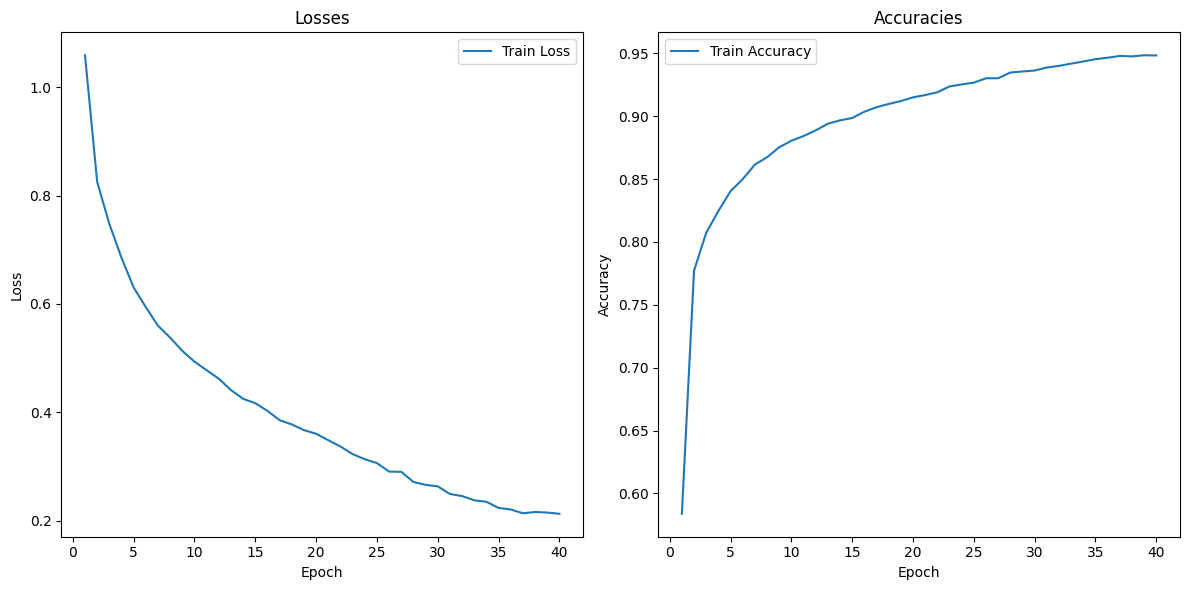

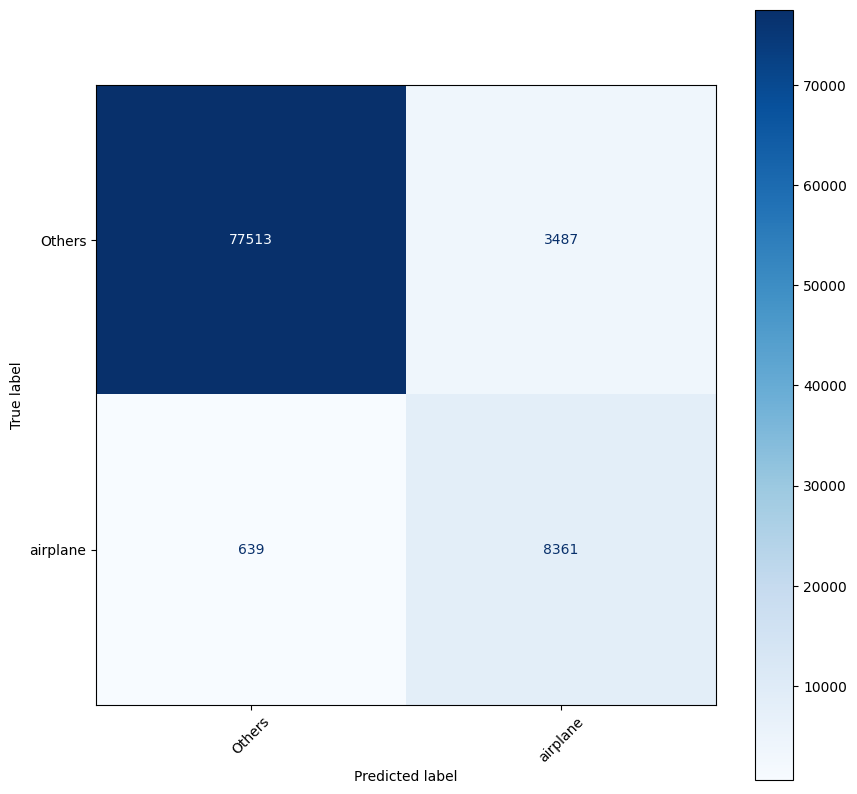

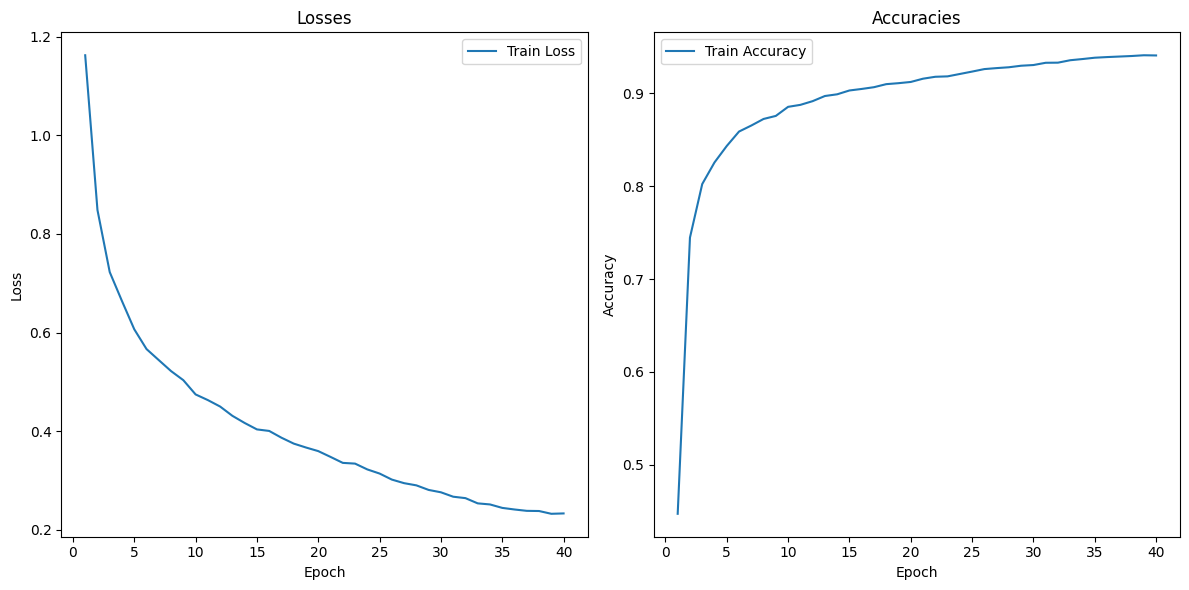

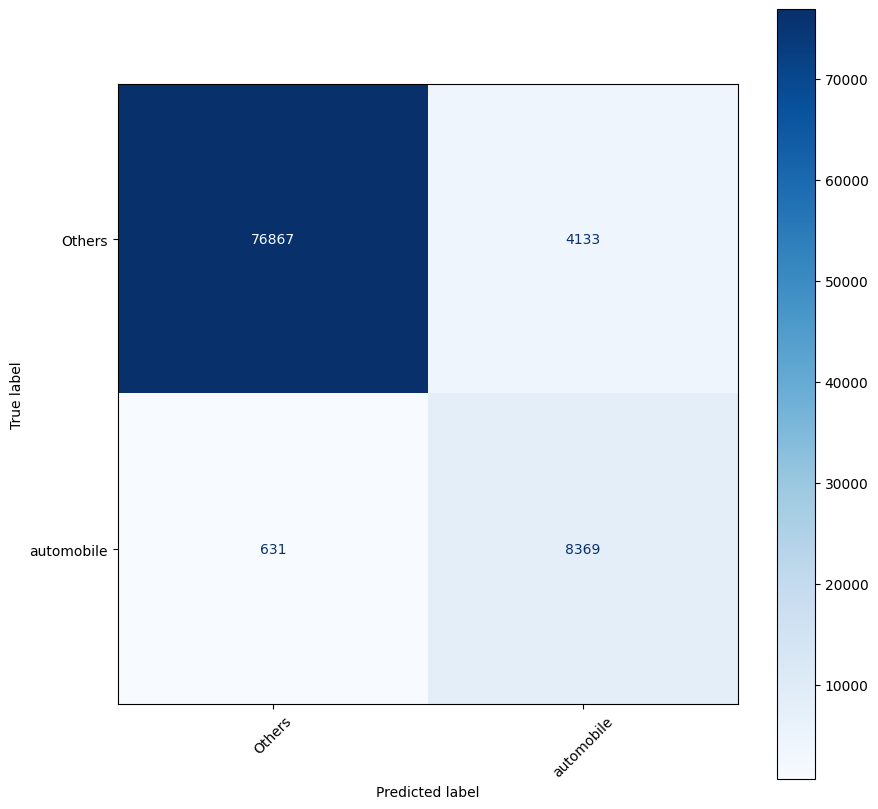

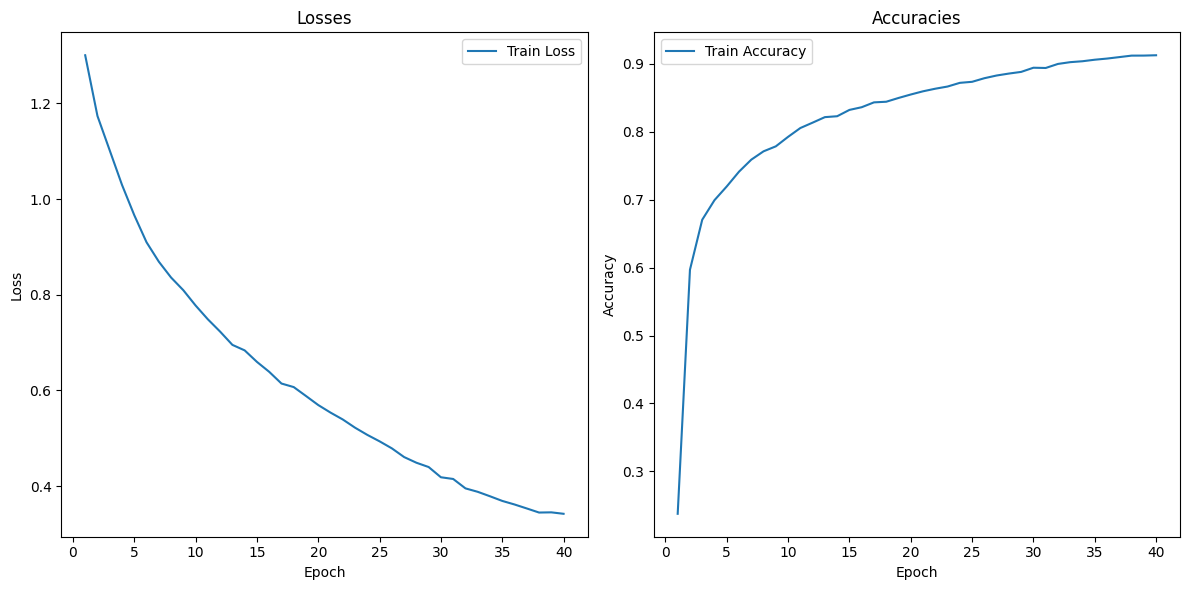

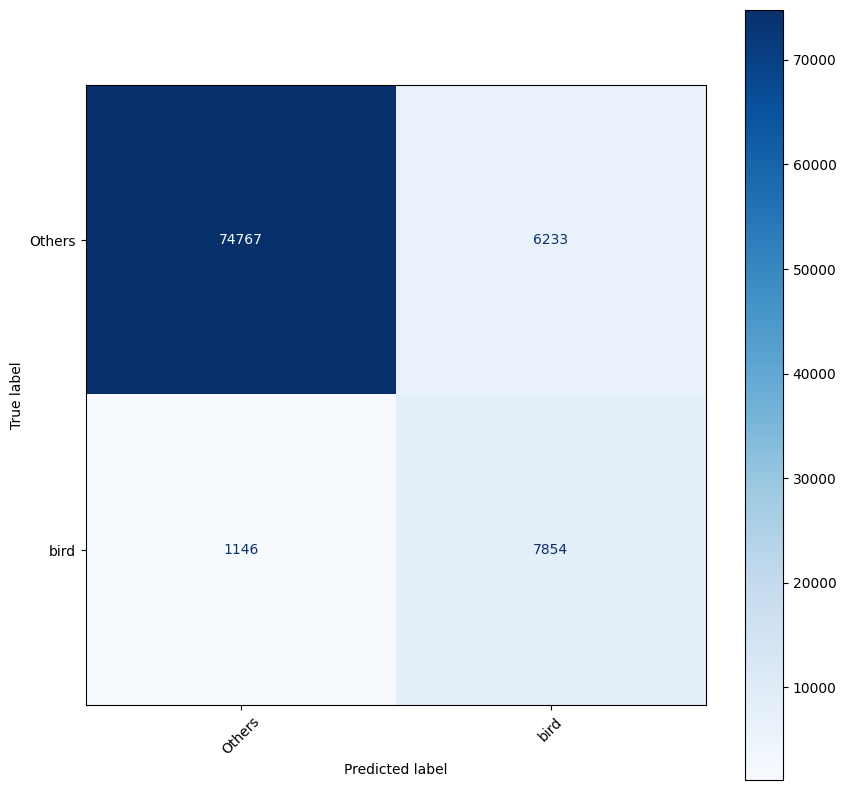

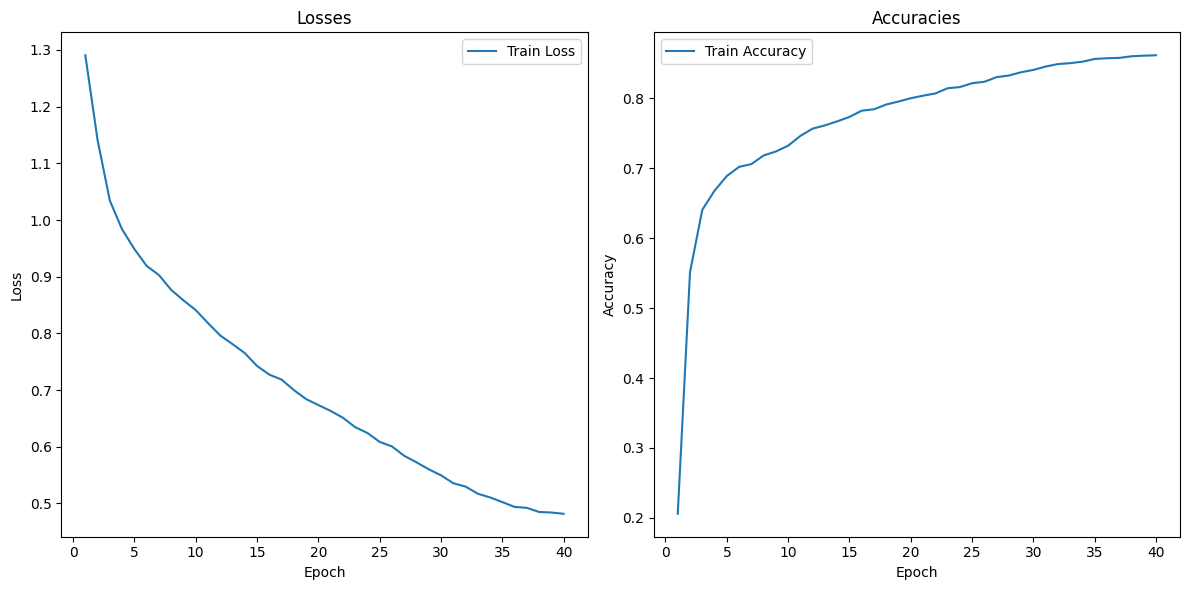

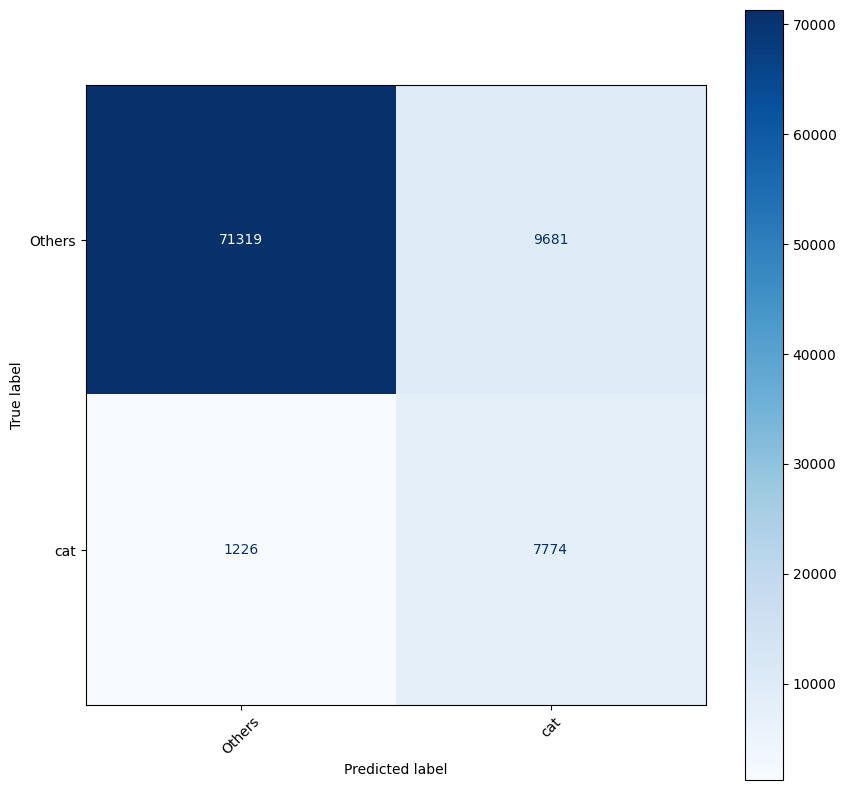

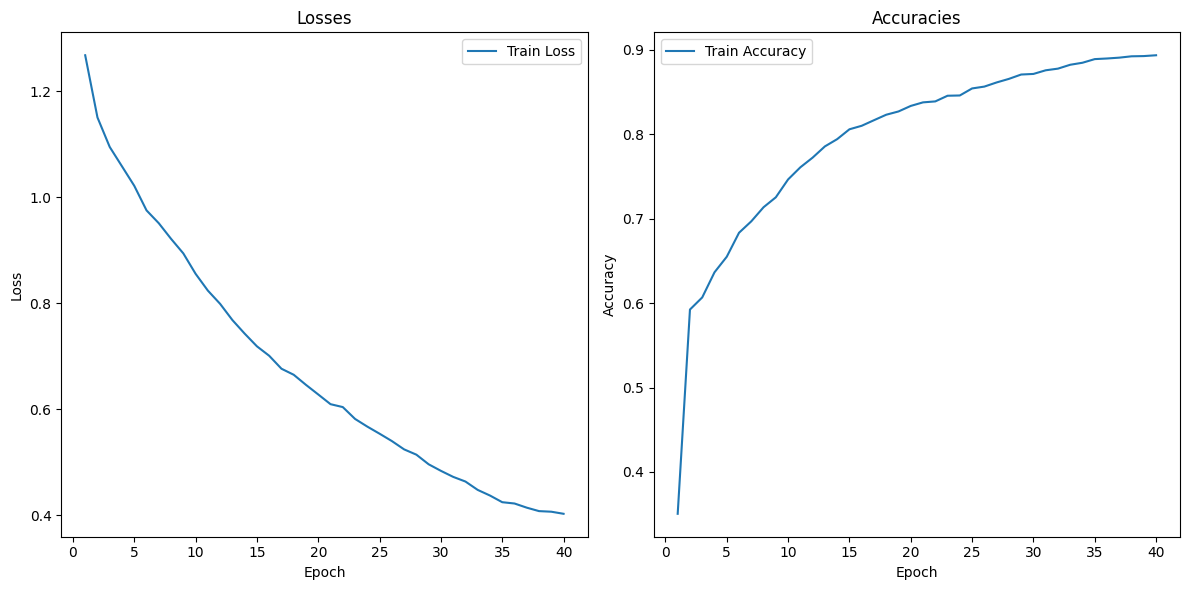

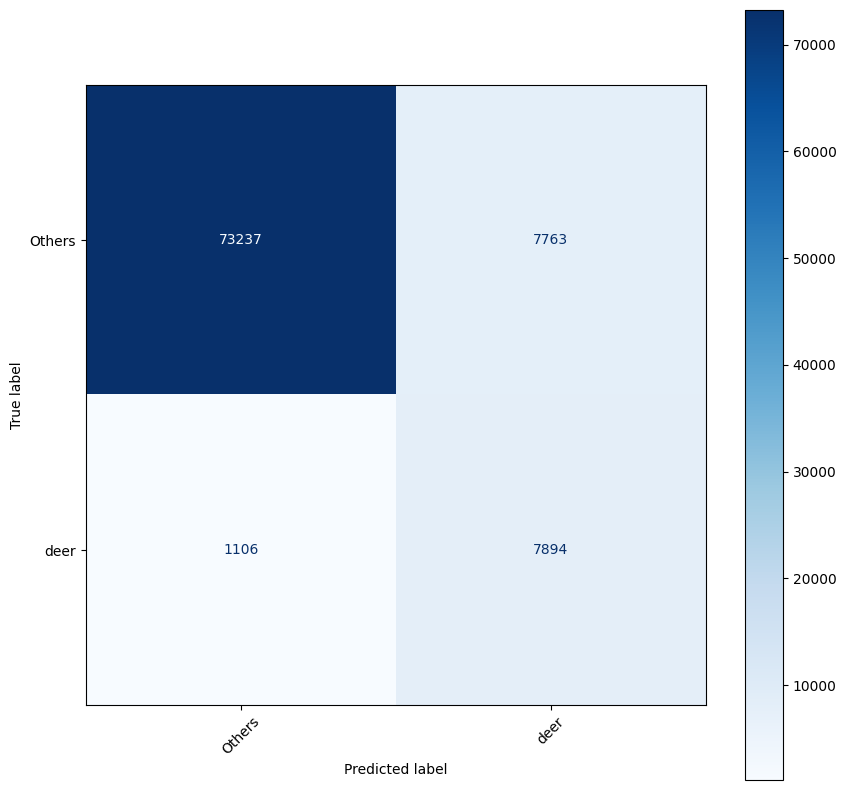

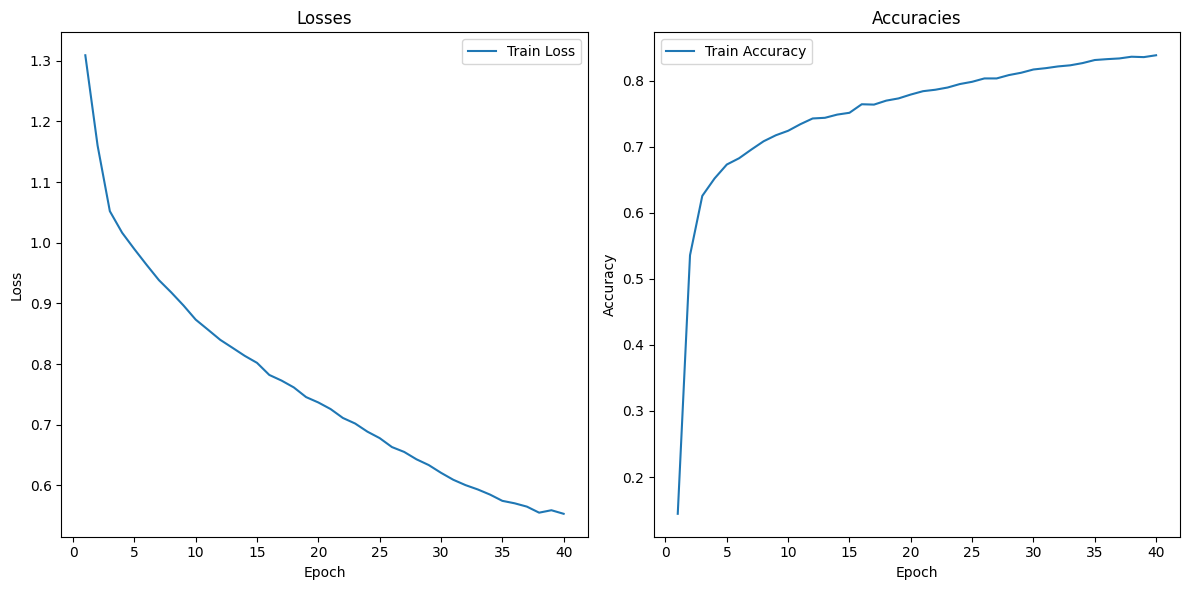

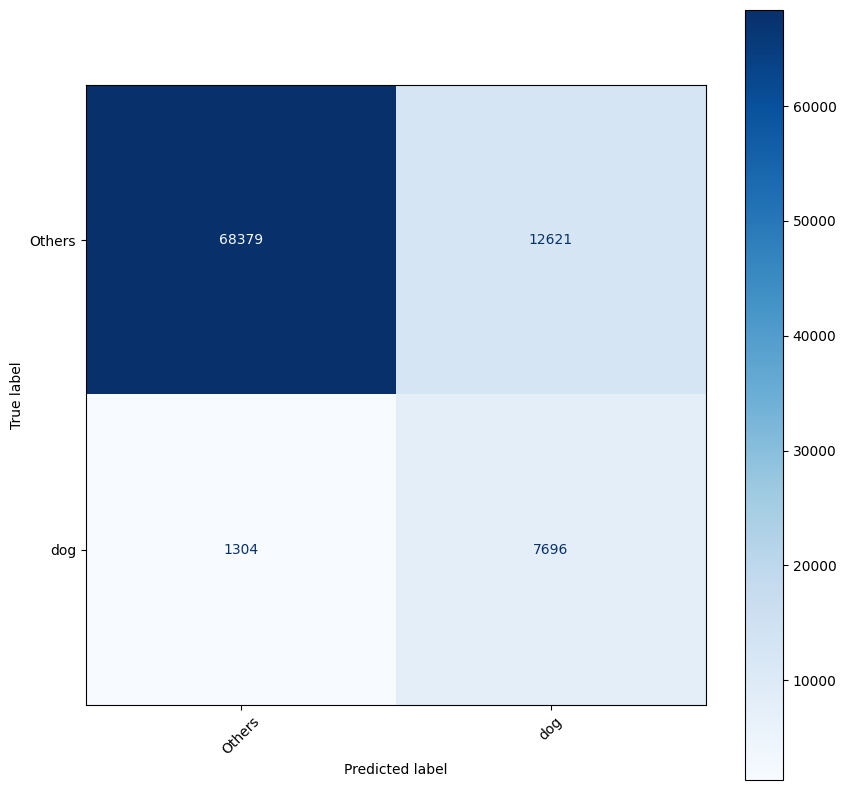

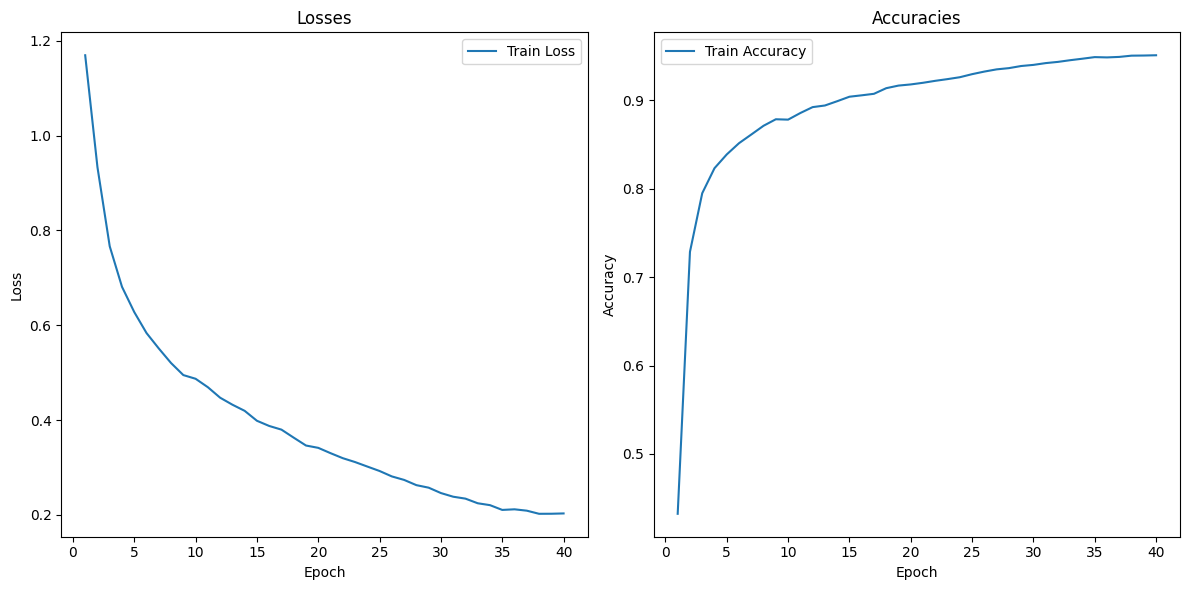

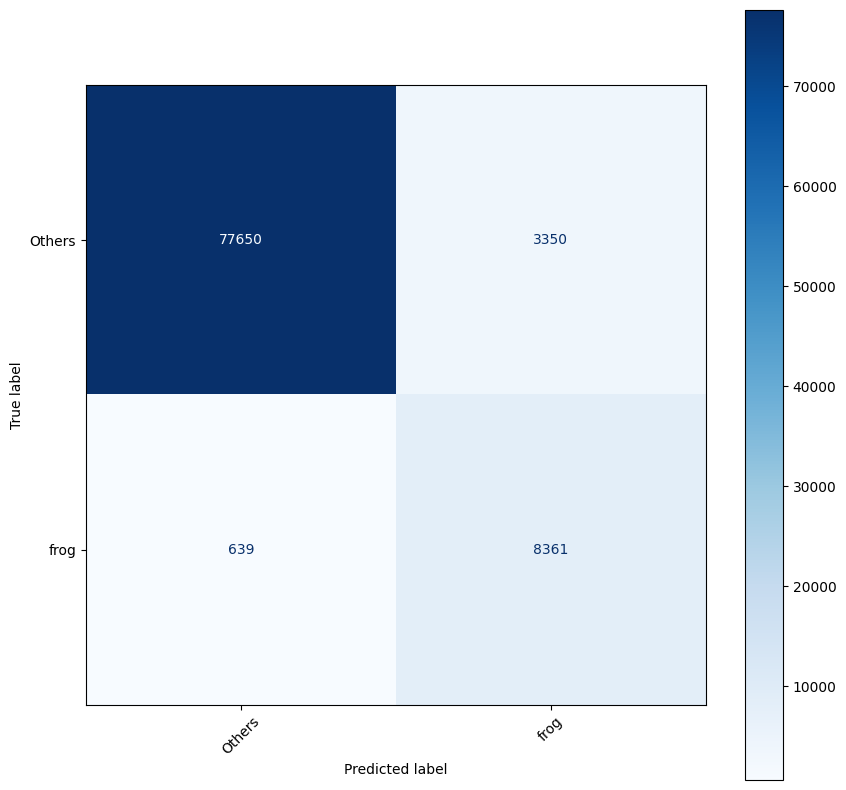

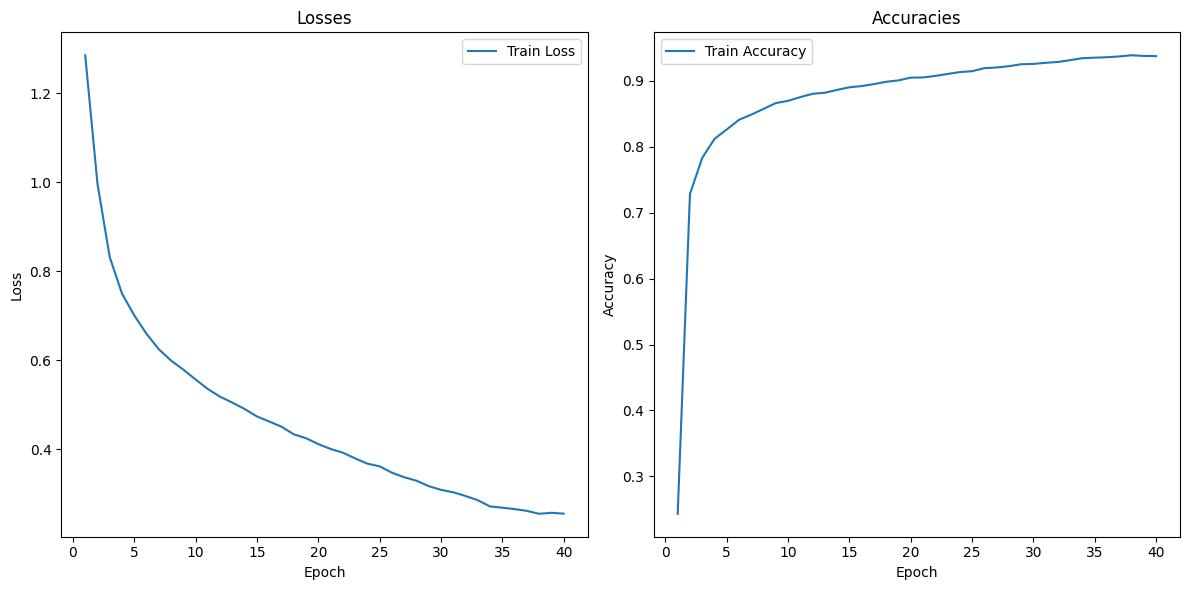

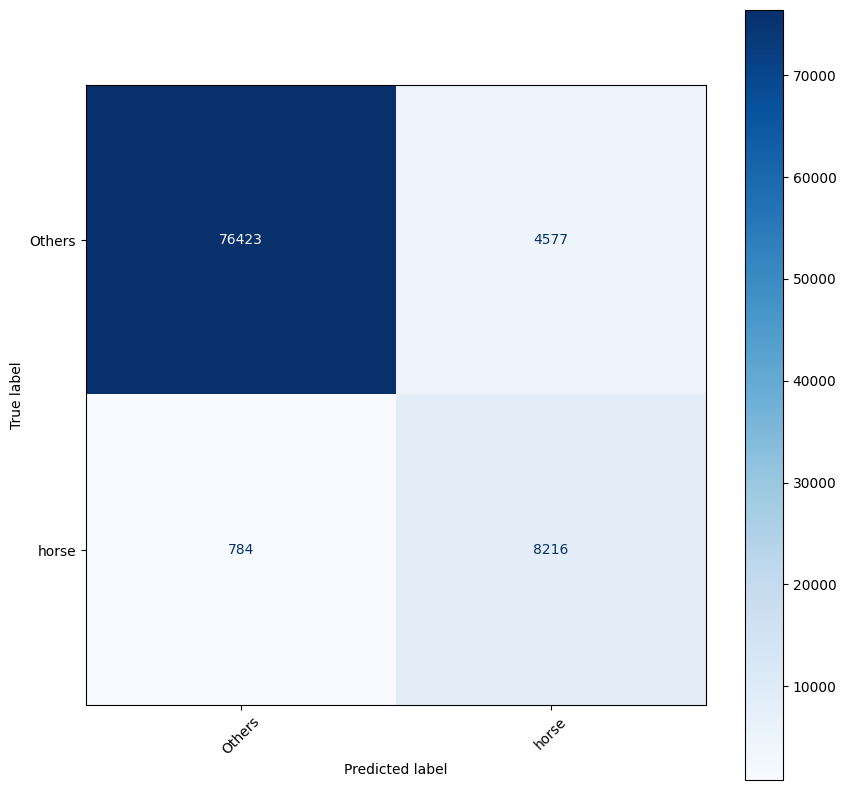

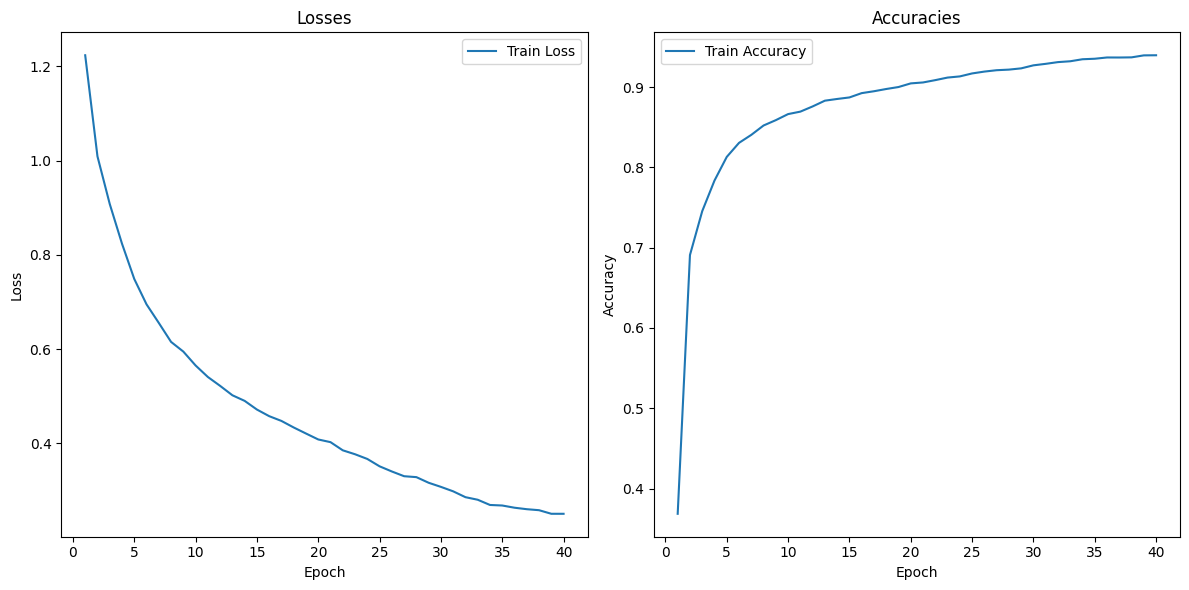

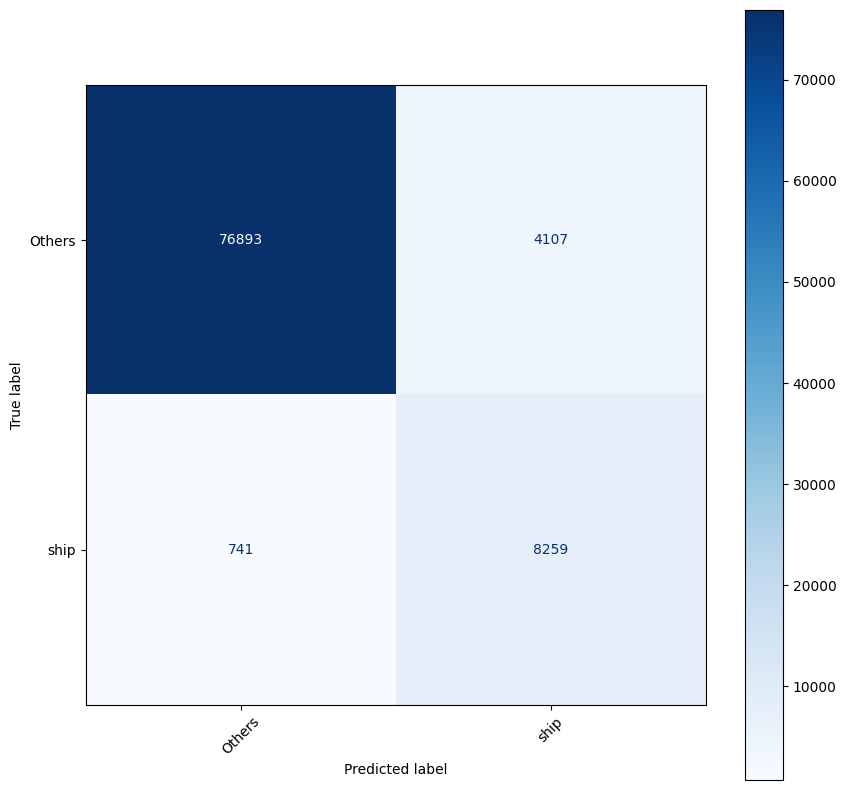

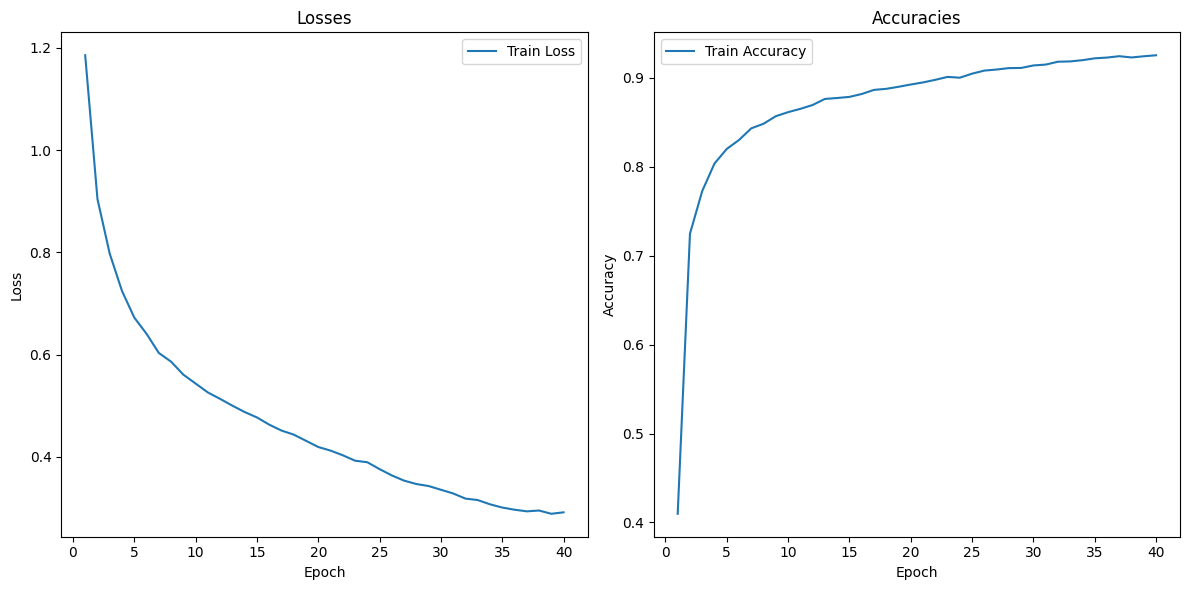

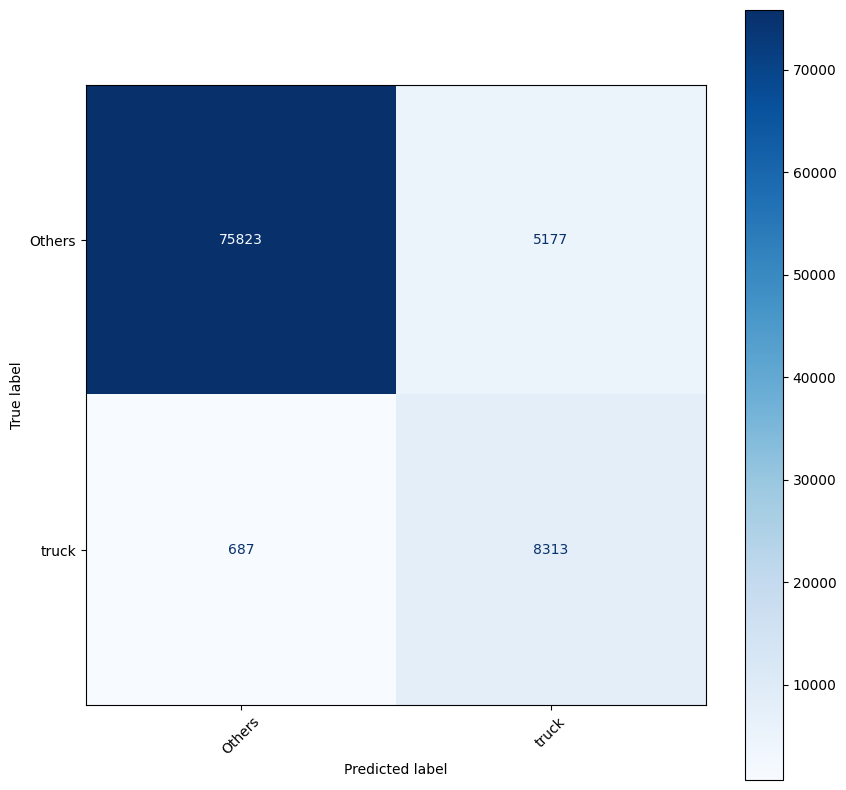

In [6]:
from pathlib import Path

main_path = Path('checkpoints/')

if not os.path.exists(main_path):
    os.makedirs(main_path)

for idx_label, labels in enumerate(LABELS):
    model = CustomCNN()
    model.to(device)

    model_name = f"CustomCNN_{idx_label}"
    seed = config["model"]["seed"]

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    optimizer = OPTIMIZERS["sgd"](
        model.parameters(),
        lr=config["training_params"]["lr"],
        momentum=0.9,
        weight_decay=1e-4,
    )
    
    # class_weights = []
    # for count in [81_000, 9000]:
    #     weight = 1 / (count / 90_000)
    #     class_weights.append(weight)
    
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([10.0]).to(device))
    scheduler = SCHEDULERS[config["training_params"]["lr_scheduler"]](
        optimizer, **config["lr_scheduler_params"]
    )

    path = main_path / f"{model_name}_seed_{seed}_augmentation_{config['data_params']['augmentation']}"
    os.makedirs(path, exist_ok=True)
    
    with open(f"{path}/config.json", "w") as f:
        json.dump(config, f)
    
    columns = ["Train Loss", "Train Accuracy"]
    df = pd.DataFrame(columns=columns)
    
    # Early stopping variables
    # patience = config["early_stopping_params"]["patience"]
    min_delta = config["early_stopping_params"]["min_delta"]
    best_val_loss = float("inf")
    # counter = 0
    
    num_epochs = config["training_params"]["no_epochs"]
    
    for epoch in tqdm(range(1, num_epochs + 1)):
        train_loss, train_accuracy = train_epoch(
            device, model, criterion, optimizer, cinic_train, idx_label=idx_label
        )
        checkpoint_name = (
            f"{model_name}_epoch_{epoch}_seed_{seed}_val_loss_{train_loss:.4f}.pth"
        )
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train_loss": train_loss,
                "train_accuracy": train_accuracy,
            },
            os.path.join(path, checkpoint_name),
        )
    
        scheduler.step()
    
        df.loc[epoch] = [train_loss, train_accuracy]
        print(f"Epoch [{epoch}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    
    plot_loss_and_acc(df, f"{path}/{model_name}_{seed}.png")
    df.to_csv(f"{path}/{model_name}_{seed}.csv")

    best_model = CustomCNN()
    checkpoint = torch.load(f"{path}/{checkpoint_name}")
    best_model.load_state_dict(checkpoint["model_state_dict"])
    best_model.to(device)
    
    _, test_accuracy = evaluate_model(
        device,
        best_model,
        criterion,
        cinic_test,
        idx_label,
        save_cm=True,
        cm_path=f"{path}/confusion_matrix.png",
    )
    print(f"Test Accuracy: {test_accuracy:.4f}")
    with open(f"{path}/test_results.txt", "w") as f:
        f.write(f"Test Accuracy: {test_accuracy:.4f}")

### Evaluation

In [7]:
from tqdm import tqdm

def calculate_accuracy(outputs, labels):
    corrects = torch.sum(outputs == labels).item()  # Assuming labels are already in device
    return corrects / len(labels)

def ensemble_predictions(models, data_loader, num_classes):
    all_predictions = []
    running_accuracy = 0.0
    
    for inputs, labels in tqdm(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)  # Move labels to the device
        
        batch_size = inputs.size(0)
        batch_predictions = torch.zeros(batch_size, num_classes).to(device)
    
        for i, model in enumerate(models):
            model.eval()
            with torch.no_grad():
                outputs = model(inputs)
                
                batch_predictions[:, i] = torch.sigmoid(outputs).squeeze()
        
        all_predictions.append(batch_predictions)
        
        # Calculate accuracy for this batch
        predicted_classes = torch.argmax(batch_predictions, dim=1)
        batch_accuracy = calculate_accuracy(predicted_classes, labels)
        running_accuracy += batch_accuracy * batch_size  # Accumulate accuracy for all batches
    
    # Calculate overall accuracy across all batches
    total_samples = len(data_loader.dataset)
    running_accuracy /= total_samples

    return running_accuracy

In [8]:
cinic_train, cinic_test = get_data(
    cinic_directory,
    batch_size=256,
    augmentation=config["data_params"]["augmentation"],
)

# Load all trained models
all_models = []
for idx_label, label in enumerate(LABELS):
    model_name = f"CustomCNN_{idx_label}"
    seed = config["model"]["seed"]
    path = main_path / f"{model_name}_seed_{seed}_augmentation_{config['data_params']['augmentation']}"

    file = [file for file in os.listdir(path) if file.endswith('.pth')][0]
    checkpoint_name = file
    
    best_model = CustomCNN()
    checkpoint = torch.load(f"{path}/{checkpoint_name}")
    best_model.load_state_dict(checkpoint["model_state_dict"])
    best_model.to(device)
    
    all_models.append(best_model)

acc = ensemble_predictions(all_models, cinic_test, len(LABELS))

100%|██████████| 352/352 [00:22<00:00, 15.85it/s]


In [9]:
acc

0.7311777777777778